In [ ]:
import pandas as pd
import os
import ast
import sklearn as skl
import sklearn.utils, sklearn.preprocessing, sklearn.decomposition, sklearn.svm
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
import numpy as np

from itertools import combinations
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn import preprocessing

import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout,Input
from keras.models import Sequential, Model
from keras.utils import to_categorical
from tensorflow.keras import optimizers

import tensorflow as tf
from tensorflow.keras import models


%matplotlib inline

In [ ]:
drive.mount('/content/drive')
%cd drive/My\ Drive/AA_PROJ_2/

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1H2HZrq04aWM2rHry2TNwQDsUieDFENJg/AA_PROJ_2


In [ ]:
df_tracks=pd.read_csv("data/FMA/FMA/fma_metadata/tracks.csv", index_col=0, header=[0, 1])
df_features=pd.read_csv("data/FMA/FMA/fma_metadata/features.csv", index_col=0, header=[0, 1, 2])
df_genres=pd.read_csv("data/FMA/FMA/fma_metadata/genres.csv")
keep_cols = [('set', 'split'),
('set', 'subset'),('track', 'genre_top')]
df_tracks_genres = df_tracks[keep_cols]
df_echo=pd.read_csv("data/FMA/FMA/fma_metadata/echonest.csv",index_col=0, header=[0, 1, 2])

In [ ]:
keep_cols = [('set', 'split'),
('set', 'subset'),('track', 'genre_top'), ('track', 'genres')]
df_tracks_genres = df_tracks[keep_cols]
df_tracks_genres = df_tracks_genres[df_tracks_genres[('set', 'subset')] == 'small']
df_tracks_genres.head()

set            track       
             split subset genre_top genres
track_id                                  
2         training  small   Hip-Hop   [21]
5         training  small   Hip-Hop   [21]
10        training  small       Pop   [10]
140       training  small      Folk   [17]
141       training  small      Folk   [17]

In [ ]:
df_tracks_genres[('track', 'genre_top')].value_counts()

Hip-Hop          1000
Experimental     1000
Electronic       1000
Rock             1000
International    1000
Pop              1000
Folk             1000
Instrumental     1000
Name: (track, genre_top), dtype: int64

In [ ]:
df_tracks_genres[('set', 'split')].value_counts()

training      6400
test           800
validation     800
Name: (set, split), dtype: int64

<h3>SVM without PCA using Librosa Dataset</h3>

In [ ]:
#masks
small   = df_tracks['set', 'subset'] == 'small'
s_train = df_tracks['set', 'split'] == 'training'
s_test  = df_tracks['set', 'split'] == 'test'
s_val   = df_tracks['set', 'split'] == 'validation'

small   =small.reset_index().drop(['track_id'],axis=1)
s_train =s_train.reset_index().drop(['track_id'],axis=1)
s_test  =s_test.reset_index().drop(['track_id'],axis=1) 
s_val   =s_val.reset_index().drop(['track_id'],axis=1) 

#normalize
df_features_clean=df_features.reset_index()
df_features_clean=df_features_clean.drop(['track_id'],axis=1)
df_features_clean=df_features_clean.values
scaler=preprocessing.StandardScaler(copy=False)
df_features_clean=scaler.fit_transform(df_features_clean)
df_features_clean=pd.DataFrame(data=df_features_clean)

df_features_train=df_features_clean.loc[small.values & (s_train.values | s_val.values)]
df_features_test=df_features_clean.loc[small.values & (s_test.values)]
df_features_train_y=df_tracks.loc[small.values & (s_train.values | s_val.values),('track', 'genre_top')]
df_features_test_y=df_tracks.loc[small.values & (s_test.values),('track', 'genre_top')]

#encode label
le=LabelEncoder()
df_features_train_y=le.fit_transform(df_features_train_y)
df_features_test_y=le.fit_transform(df_features_test_y)

#train 
clf_svc_pca = SVC()
clf_svc_pca.fit(df_features_train, df_features_train_y)

#test
predictions=clf_svc_pca.predict(df_features_test)
labels = [0,1,2,3,4,5,6,7]
target_names = le.inverse_transform(labels)
print(classification_report(df_features_test_y, predictions, target_names=target_names))

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


               precision    recall  f1-score   support

   Electronic       0.60      0.64      0.62       100
 Experimental       0.42      0.43      0.42       100
         Folk       0.24      0.23      0.23       100
      Hip-Hop       0.68      0.73      0.70       100
 Instrumental       0.45      0.45      0.45       100
International       0.57      0.46      0.51       100
          Pop       0.39      0.39      0.39       100
         Rock       0.61      0.63      0.62       100

     accuracy                           0.49       800
    macro avg       0.49      0.50      0.49       800
 weighted avg       0.49      0.49      0.49       800



<h3>SVM with PCA using Librosa Dataset</h3>

In [ ]:
#masks
small   = df_tracks['set', 'subset'] == 'small'
s_train = df_tracks['set', 'split'] == 'training'
s_test  = df_tracks['set', 'split'] == 'test'
s_val   = df_tracks['set', 'split'] == 'validation'

small   =small.reset_index().drop(['track_id'],axis=1)
s_train =s_train.reset_index().drop(['track_id'],axis=1)
s_test  =s_test.reset_index().drop(['track_id'],axis=1) 
s_val   =s_val.reset_index().drop(['track_id'],axis=1) 

#normalize
df_features_clean=df_features.reset_index()
df_features_clean=df_features_clean.drop(['track_id'],axis=1)
df_features_clean=df_features_clean.values
scaler_pca=preprocessing.StandardScaler(copy=False)
df_features_clean=scaler_pca.fit_transform(df_features_clean)

print(df_features_clean.shape)
#pca
pca=PCA(0.90)
principal_components=pca.fit_transform(df_features_clean)
df_features_pca=pd.DataFrame(data=principal_components)
print(df_features_pca.shape)

df_features_train=df_features_pca.loc[small.values & (s_train.values | s_val.values)]
df_features_test=df_features_pca.loc[small.values & (s_test.values)]
df_features_train_y=df_tracks.loc[small.values & (s_train.values | s_val.values),('track', 'genre_top')]
df_features_test_y=df_tracks.loc[small.values & (s_test.values),('track', 'genre_top')]

#encode label
le=LabelEncoder()
df_features_train_y=le.fit_transform(df_features_train_y)
df_features_test_y=le.fit_transform(df_features_test_y)

#train 
clf_svc_pca = SVC()
clf_svc_pca.fit(df_features_train, df_features_train_y)

#test
predictions=clf_svc_pca.predict(df_features_test)
labels = [0,1,2,3,4,5,6,7]
target_names = le.inverse_transform(labels)
print(classification_report(df_features_test_y, predictions, target_names=target_names))

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


(106574, 518)
(106574, 151)
               precision    recall  f1-score   support

   Electronic       0.56      0.62      0.59       100
 Experimental       0.43      0.42      0.43       100
         Folk       0.22      0.22      0.22       100
      Hip-Hop       0.66      0.71      0.69       100
 Instrumental       0.43      0.46      0.44       100
International       0.58      0.46      0.51       100
          Pop       0.35      0.35      0.35       100
         Rock       0.64      0.63      0.63       100

     accuracy                           0.48       800
    macro avg       0.48      0.48      0.48       800
 weighted avg       0.48      0.48      0.48       800



<h3>Neural Network using Librosa Dataset</h3>

In [ ]:
import matplotlib.pyplot as plt

def plot_acc_loss(result, epochs):
    acc = result.history['accuracy']
    loss = result.history['loss']
    val_acc = result.history['val_accuracy']
    val_loss = result.history['val_loss']
    plt.figure(figsize=(15, 5))
    plt.subplot(121)
    plt.plot(range(1,epochs), acc[1:], label='Train_acc')
    plt.plot(range(1,epochs), val_acc[1:], label='Test_acc')
    plt.title('Accuracy over ' + str(epochs) + ' Epochs', size=15)
    plt.legend()
    plt.grid(True)
    plt.subplot(122)
    plt.plot(range(1,epochs), loss[1:], label='Train_loss')
    plt.plot(range(1,epochs), val_loss[1:], label='Test_loss')
    plt.title('Loss over ' + str(epochs) + ' Epochs', size=15)
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
def create_model(inpt_shape, nout, lyrs=[32, 32, 16], dr=0.5, droprate=0.0005):
    inputs = Input(shape=inpt_shape)
    x=Dense(lyrs[0],activation='relu')(inputs)
    
    # Generate new hidden layers 
    for i in range(1,len(lyrs)):
        x=Dense(lyrs[i], activation='relu')(x)
        x=Dropout(dr)(x)
    
    # output layer, sigmoid since we are dealing with a binary classificatio problem
    outputs=Dense(nout, activation='sigmoid')(x) 

    model=Model(inputs=inputs, outputs=outputs)
    # Loss function used is 'binary_crossentropy',  since we are dealing with a binary classificatio problem
    #We use accuracy to compare values further in our optimization 
    model.compile(loss='categorical_crossentropy',optimizer=optimizers.Adam(lr=droprate),metrics=['accuracy',tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.TruePositives(),  tf.keras.metrics.TrueNegatives(),  tf.keras.metrics.FalsePositives(),  tf.keras.metrics.FalseNegatives()])
    
    return model

In [ ]:
#masks
small   = df_tracks['set', 'subset'] == 'small'
s_train = df_tracks['set', 'split'] == 'training'
s_test  = df_tracks['set', 'split'] == 'test'
s_val   = df_tracks['set', 'split'] == 'validation'

small   =small.reset_index().drop(['track_id'],axis=1)
s_train =s_train.reset_index().drop(['track_id'],axis=1)
s_test  =s_test.reset_index().drop(['track_id'],axis=1) 
s_val   =s_val.reset_index().drop(['track_id'],axis=1) 

#normalize
df_features_clean=df_features.reset_index()
df_features_clean=df_features_clean.drop(['track_id'],axis=1)
df_features_clean=df_features_clean.values
scaler=preprocessing.StandardScaler(copy=False)
df_features_clean=scaler.fit_transform(df_features_clean)
df_features_clean=pd.DataFrame(data=df_features_clean)

df_features_train=df_features_clean.loc[small.values & s_train.values]
df_features_valid=df_features_clean.loc[small.values & s_val.values]
df_features_test=df_features_clean.loc[small.values & s_test.values]

df_features_train_y=df_tracks.loc[small.values & s_train.values,('track', 'genre_top')]
df_features_valid_y=df_tracks.loc[small.values & s_val.values,('track', 'genre_top')]
df_features_test_y=df_tracks.loc[small.values & s_test.values,('track', 'genre_top')]

#encode label
le=LabelEncoder()
df_features_train_y=le.fit_transform(df_features_train_y)
df_features_valid_y=le.fit_transform(df_features_valid_y)
df_features_test_y=le.fit_transform(df_features_test_y)

df_features_train_y = to_categorical(df_features_train_y)
df_features_valid_y = to_categorical(df_features_valid_y)
df_features_test_y = to_categorical(df_features_test_y)

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


[128, 128]
Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 518)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 128)               66432     
_________________________________________________________________
dense_11 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 8)                 1032      
Total params: 83,976
Trainable params: 83,976
Non-trainable params: 0
_________________________________________________________________
None
Train on 6400 samples, validate on 800 samples
Epoch 1/35
6400/6400 [==============================] - 2s

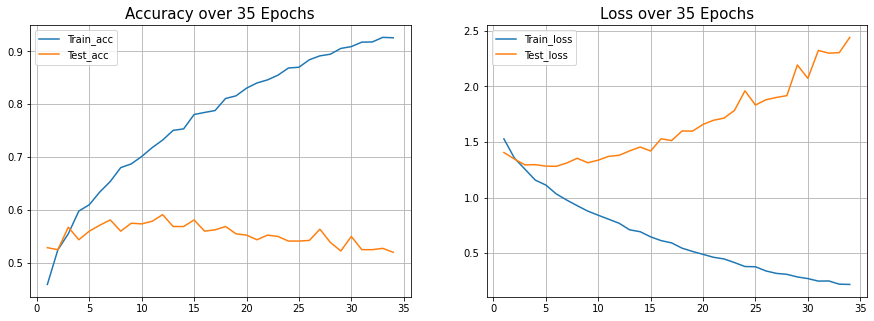

[64, 64]
Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 518)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 64)                33216     
_________________________________________________________________
dense_14 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 8)                 520       
Total params: 37,896
Trainable params: 37,896
Non-trainable params: 0
_________________________________________________________________
None
Train on 6400 samples, validate on 800 samples
Epoch 1/35
6400/6400 [==============================] - 2s 2

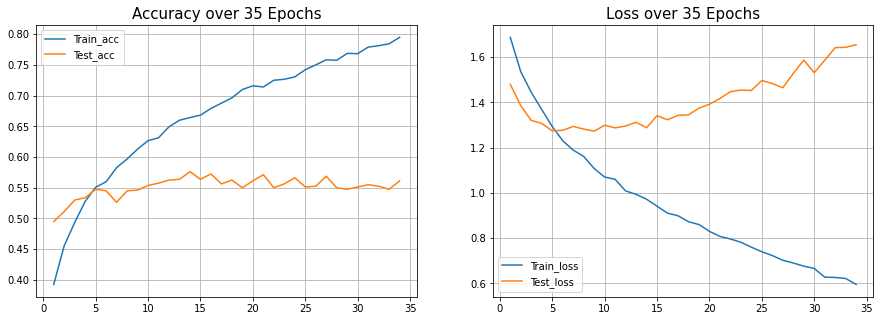

[32, 32]
Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 518)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 32)                16608     
_________________________________________________________________
dense_17 (Dense)             (None, 32)                1056      
_________________________________________________________________
dropout_6 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_18 (Dense)             (None, 8)                 264       
Total params: 17,928
Trainable params: 17,928
Non-trainable params: 0
_________________________________________________________________
None
Train on 6400 samples, validate on 800 samples
Epoch 1/35
6400/6400 [==============================] - 2s 2

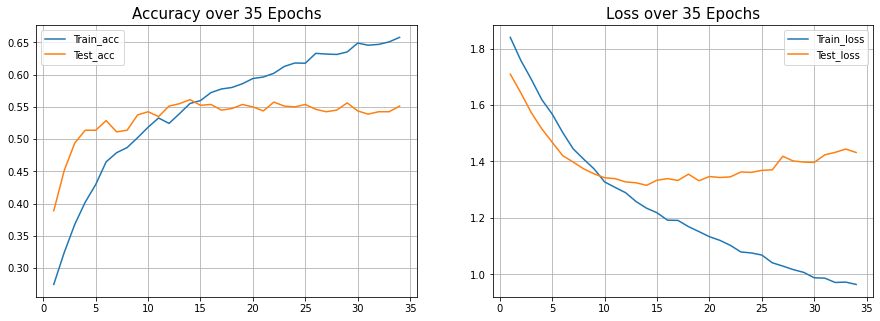

[32, 16]
Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 518)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 32)                16608     
_________________________________________________________________
dense_20 (Dense)             (None, 16)                528       
_________________________________________________________________
dropout_7 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_21 (Dense)             (None, 8)                 136       
Total params: 17,272
Trainable params: 17,272
Non-trainable params: 0
_________________________________________________________________
None
Train on 6400 samples, validate on 800 samples
Epoch 1/35
6400/6400 [==============================] - 2s 2

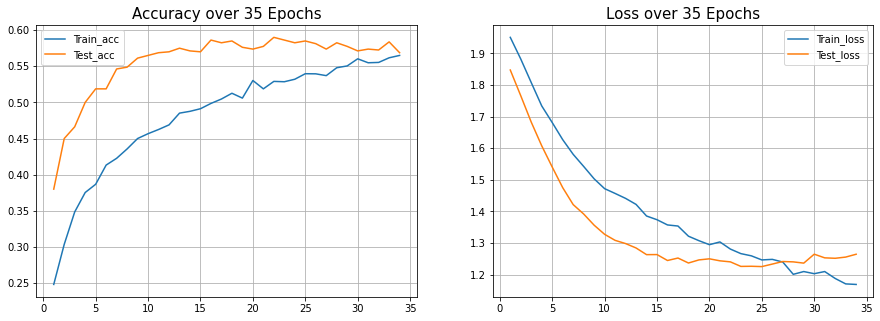

[16, 16]
Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 518)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 16)                8304      
_________________________________________________________________
dense_23 (Dense)             (None, 16)                272       
_________________________________________________________________
dropout_8 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_24 (Dense)             (None, 8)                 136       
Total params: 8,712
Trainable params: 8,712
Non-trainable params: 0
_________________________________________________________________
None
Train on 6400 samples, validate on 800 samples
Epoch 1/35
6400/6400 [==============================] - 2s 272

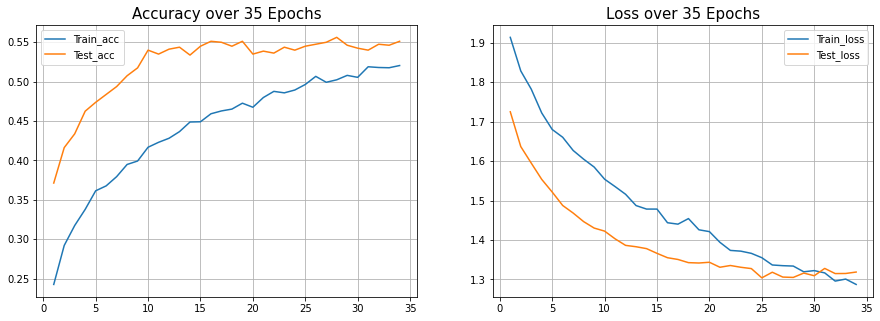

[32, 32, 16]
Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 518)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 32)                16608     
_________________________________________________________________
dense_26 (Dense)             (None, 32)                1056      
_________________________________________________________________
dropout_9 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_27 (Dense)             (None, 16)                528       
_________________________________________________________________
dropout_10 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_28 (Dense)             (None, 8)        

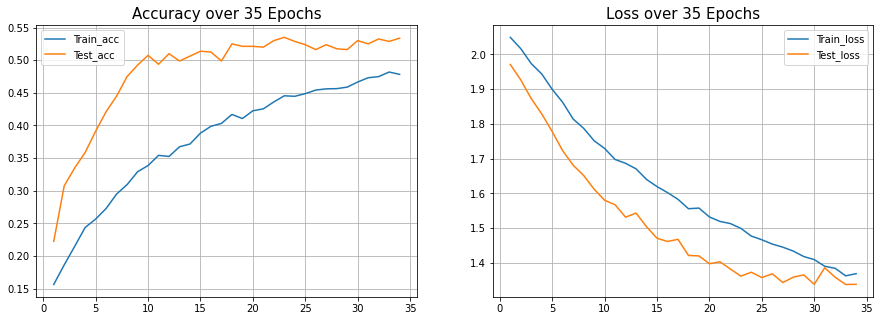

[32, 64, 32]
Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 518)               0         
_________________________________________________________________
dense_29 (Dense)             (None, 32)                16608     
_________________________________________________________________
dense_30 (Dense)             (None, 64)                2112      
_________________________________________________________________
dropout_11 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_31 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_12 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_32 (Dense)             (None, 8)       

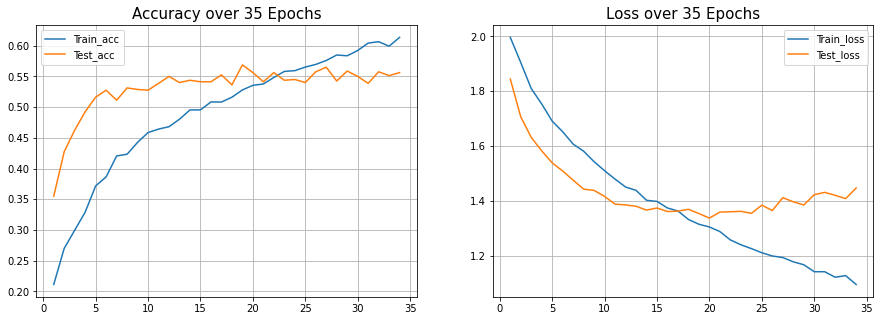

[128, 64, 64]
Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 518)               0         
_________________________________________________________________
dense_33 (Dense)             (None, 128)               66432     
_________________________________________________________________
dense_34 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_13 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_35 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_14 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_36 (Dense)             (None, 8)      

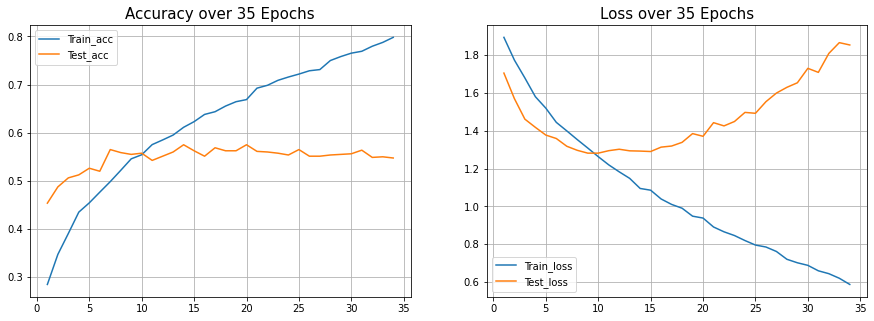

[64, 64, 32]
Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 518)               0         
_________________________________________________________________
dense_37 (Dense)             (None, 64)                33216     
_________________________________________________________________
dense_38 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_15 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_39 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_16 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_40 (Dense)             (None, 8)       

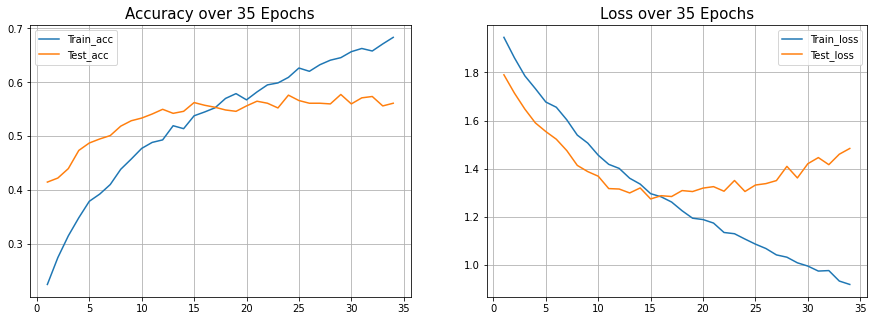

[32, 32, 32]
Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        (None, 518)               0         
_________________________________________________________________
dense_41 (Dense)             (None, 32)                16608     
_________________________________________________________________
dense_42 (Dense)             (None, 32)                1056      
_________________________________________________________________
dropout_17 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_43 (Dense)             (None, 32)                1056      
_________________________________________________________________
dropout_18 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_44 (Dense)             (None, 8)       

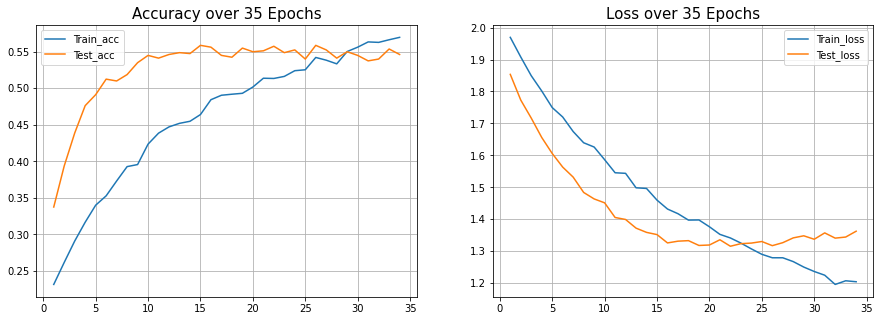

[[16, 16, 16]]


TypeError: ignored

In [ ]:
layers=[[128,128],[64,64],[32,32],[32,16],[16,16],[32,32,16],[32,64,32],
        [128,64,64],[64,64,32],[32,32,32],[16,16,16]]

for l in layers:
  print(l)
  model=create_model((df_features_train.shape[1],),8,lyrs=l, dr=0.5, droprate=0.00025)
  print(model.summary())
  history = model.fit(df_features_train, df_features_train_y,
                      batch_size=16,
                      epochs=35,
                      validation_data=(df_features_valid, df_features_valid_y))

  plot_acc_loss(history, 35)

In [ ]:
df_features_train.shape[1]

518

Model: "model_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_29 (InputLayer)        (None, 518)               0         
_________________________________________________________________
dense_99 (Dense)             (None, 32)                16608     
_________________________________________________________________
dense_100 (Dense)            (None, 16)                528       
_________________________________________________________________
dropout_44 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_101 (Dense)            (None, 8)                 136       
Total params: 17,272
Trainable params: 17,272
Non-trainable params: 0
_________________________________________________________________
None
Train on 6400 samples, validate on 800 samples
Epoch 1/25
6400/6400 [==============================] - 2s 276us/ste

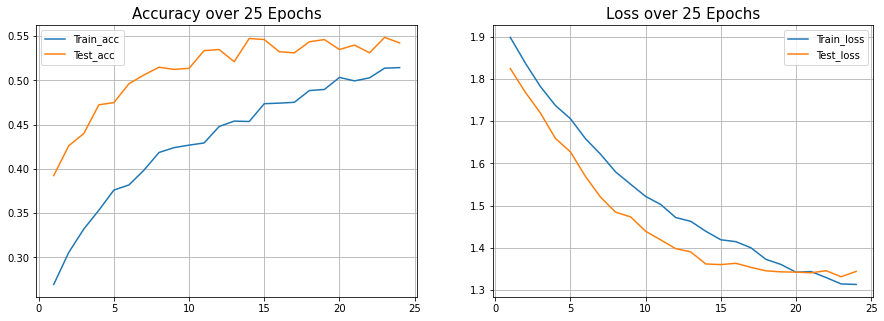

800/800 [==============================] - 0s 82us/step
Test loss: 1.5184549856185914
Test accuracy: 0.49125000834465027
Test precision: 0.2926490306854248
Test Recall: 0.598427414894104
Test F1 Score:  0.3930733525122986


In [ ]:
model=create_model((df_features_train.shape[1],),8,lyrs=[32,16], dr=0.5, droprate=0.00025)
print(model.summary())
history = model.fit(df_features_train, df_features_train_y,
                    batch_size=16,
                    epochs=25,
                    validation_data=(df_features_valid, df_features_valid_y))

plot_acc_loss(history, 25)
x= model.evaluate(df_features_test.values,df_features_test_y)
print('Test loss:' , x[0])
print('Test accuracy:',x[1])
print('Test precision:' , x[2])
print('Test Recall:',x[3])
print('Test F1 Score: ',2*(x[2]*x[3])/(x[2]+x[3]))

<h3>Neural Network with PCA using Librosa Dataset</h3>

In [ ]:
#masks
small   = df_tracks['set', 'subset'] == 'small'
s_train = df_tracks['set', 'split'] == 'training'
s_test  = df_tracks['set', 'split'] == 'test'
s_val   = df_tracks['set', 'split'] == 'validation'

small   =small.reset_index().drop(['track_id'],axis=1)
s_train =s_train.reset_index().drop(['track_id'],axis=1)
s_test  =s_test.reset_index().drop(['track_id'],axis=1) 
s_val   =s_val.reset_index().drop(['track_id'],axis=1) 

#normalize
df_features_clean=df_features.reset_index()
df_features_clean=df_features_clean.drop(['track_id'],axis=1)
df_features_clean=df_features_clean.values
scaler=preprocessing.StandardScaler(copy=False)
df_features_clean=scaler.fit_transform(df_features_clean)
#df_features_clean=pd.DataFrame(data=df_features_clean)

pca=PCA(0.90)
principal_components=pca.fit_transform(df_features_clean)
df_features_clean=pd.DataFrame(data=principal_components)

df_features_train=df_features_clean.loc[small.values & s_train.values]
df_features_valid=df_features_clean.loc[small.values & s_val.values]
df_features_test=df_features_clean.loc[small.values & s_test.values]

df_features_train_y=df_tracks.loc[small.values & s_train.values,('track', 'genre_top')]
df_features_valid_y=df_tracks.loc[small.values & s_val.values,('track', 'genre_top')]
df_features_test_y=df_tracks.loc[small.values & s_test.values,('track', 'genre_top')]

#encode label
le=LabelEncoder()
df_features_train_y=le.fit_transform(df_features_train_y)
df_features_valid_y=le.fit_transform(df_features_valid_y)
df_features_test_y=le.fit_transform(df_features_test_y)

df_features_train_y = to_categorical(df_features_train_y)
df_features_valid_y = to_categorical(df_features_valid_y)
df_features_test_y = to_categorical(df_features_test_y)

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


[128, 128]
Train on 6400 samples, validate on 800 samples
Epoch 1/35
6400/6400 [==============================] - 2s 280us/step - loss: 2.0037 - accuracy: 0.2322 - precision_4: 0.1374 - recall_4: 0.7035 - true_positives_4: 2384.2051 - true_negatives_4: 8230.5322 - false_positives_4: 14225.4678 - false_negatives_4: 823.7950 - val_loss: 1.7338 - val_accuracy: 0.3800 - val_precision_4: 0.1578 - val_recall_4: 0.7790 - val_true_positives_4: 5304.1401 - val_true_negatives_4: 19359.8398 - val_false_positives_4: 28296.1602 - val_false_negatives_4: 1503.8600
Epoch 2/35
6400/6400 [==============================] - 2s 250us/step - loss: 1.7311 - accuracy: 0.3775 - precision_4: 0.1762 - recall_4: 0.7703 - true_positives_4: 7993.0698 - true_negatives_4: 35750.7344 - false_positives_4: 37105.2656 - false_negatives_4: 2414.9299 - val_loss: 1.5188 - val_accuracy: 0.4400 - val_precision_4: 0.1927 - val_recall_4: 0.7432 - val_true_positives_4: 10410.5400 - val_true_negatives_4: 54458.2617 - val_false_po

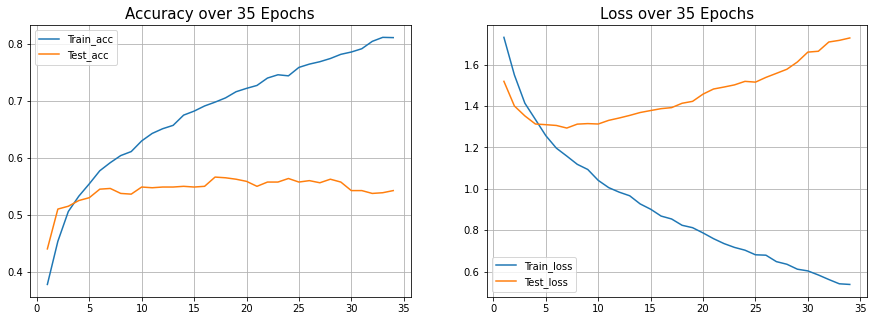

800/800 [==============================] - 0s 84us/step
Test loss: 2.1802727818489074
Test accuracy: 0.44624999165534973
Test precision: 0.5031289458274841
Test Recall: 0.35514479875564575
Test F1 Score:  0.41637910827816377
[64, 64]
Train on 6400 samples, validate on 800 samples
Epoch 1/35
6400/6400 [==============================] - 2s 277us/step - loss: 2.0837 - accuracy: 0.1844 - precision_5: 0.1341 - recall_5: 0.6825 - true_positives_5: 2274.7200 - true_negatives_5: 8161.4600 - false_positives_5: 14294.5400 - false_negatives_5: 933.2800 - val_loss: 1.9131 - val_accuracy: 0.3225 - val_precision_5: 0.1432 - val_recall_5: 0.7604 - val_true_positives_5: 5177.8999 - val_true_negatives_5: 16674.6797 - val_false_positives_5: 30981.3203 - val_false_negatives_5: 1630.1000
Epoch 2/35
6400/6400 [==============================] - 2s 243us/step - loss: 1.9295 - accuracy: 0.2547 - precision_5: 0.1484 - recall_5: 0.7879 - true_positives_5: 8216.5820 - true_negatives_5: 25888.2930 - false_positiv

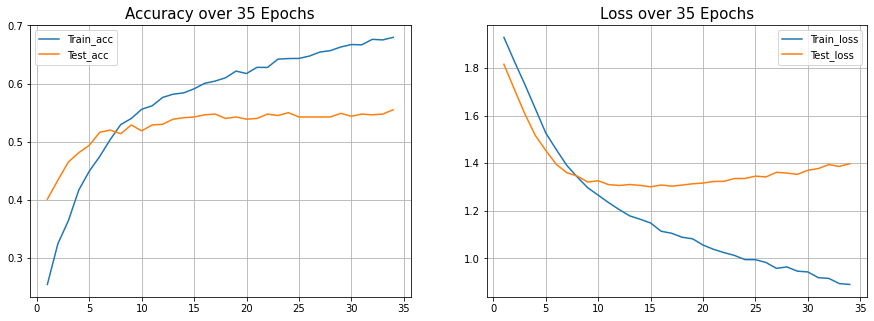

800/800 [==============================] - 0s 98us/step
Test loss: 1.835446116924286
Test accuracy: 0.44624999165534973
Test precision: 0.38980188965797424
Test Recall: 0.48471692204475403
Test F1 Score:  0.43210865137219934
[32, 32]
Train on 6400 samples, validate on 800 samples
Epoch 1/35
6400/6400 [==============================] - 2s 291us/step - loss: 2.1773 - accuracy: 0.1439 - precision_6: 0.1339 - recall_6: 0.5453 - true_positives_6: 1768.4025 - true_negatives_6: 10963.0400 - false_positives_6: 11492.9600 - false_negatives_6: 1439.5975 - val_loss: 2.0003 - val_accuracy: 0.2000 - val_precision_6: 0.1380 - val_recall_6: 0.5912 - val_true_positives_6: 4025.7600 - val_true_negatives_6: 22519.5195 - val_false_positives_6: 25136.4805 - val_false_negatives_6: 2782.2400
Epoch 2/35
6400/6400 [==============================] - 2s 254us/step - loss: 2.0154 - accuracy: 0.2072 - precision_6: 0.1438 - recall_6: 0.6275 - true_positives_6: 6558.1851 - true_negatives_6: 33940.5352 - false_posit

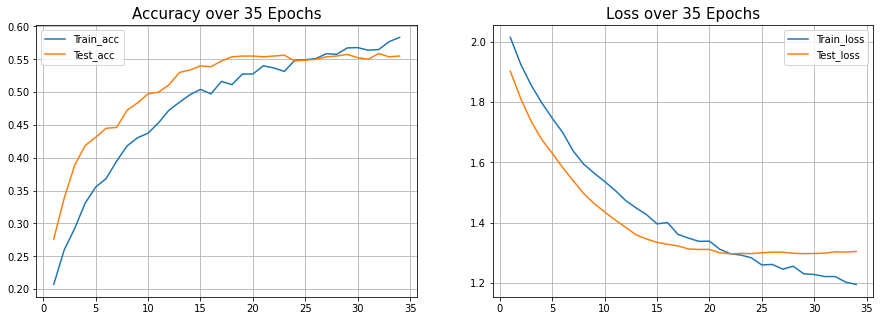

800/800 [==============================] - 0s 92us/step
Test loss: 1.5649047136306762
Test accuracy: 0.45249998569488525
Test precision: 0.3293655812740326
Test Recall: 0.5769363641738892
Test F1 Score:  0.41933702536706985
[32, 16]
Train on 6400 samples, validate on 800 samples
Epoch 1/35
6400/6400 [==============================] - 2s 281us/step - loss: 2.1095 - accuracy: 0.1525 - precision_7: 0.1317 - recall_7: 0.5403 - true_positives_7: 1780.6125 - true_negatives_7: 10979.8477 - false_positives_7: 11476.1523 - false_negatives_7: 1427.3875 - val_loss: 2.0166 - val_accuracy: 0.2037 - val_precision_7: 0.1389 - val_recall_7: 0.5814 - val_true_positives_7: 3958.5000 - val_true_negatives_7: 23122.5000 - val_false_positives_7: 24533.5000 - val_false_negatives_7: 2849.5000
Epoch 2/35
6400/6400 [==============================] - 2s 251us/step - loss: 2.0307 - accuracy: 0.1889 - precision_7: 0.1421 - recall_7: 0.5974 - true_positives_7: 6228.4199 - true_negatives_7: 35316.0781 - false_positi

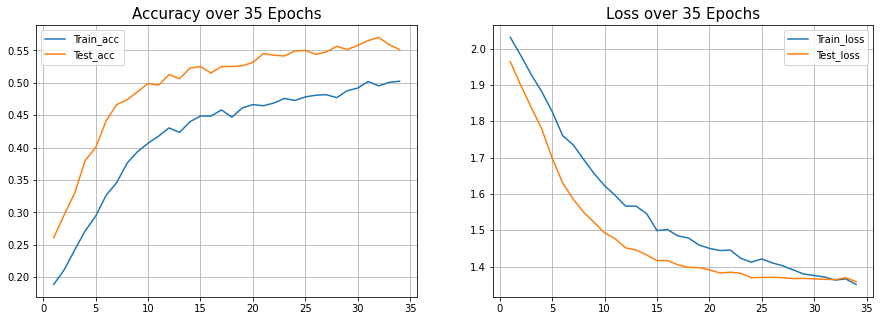

800/800 [==============================] - 0s 86us/step
Test loss: 1.546878912448883
Test accuracy: 0.4300000071525574
Test precision: 0.29864954948425293
Test Recall: 0.5087225437164307
Test F1 Score:  0.3763562297306972
[16, 16]
Train on 6400 samples, validate on 800 samples
Epoch 1/35
6400/6400 [==============================] - 2s 274us/step - loss: 2.1564 - accuracy: 0.1505 - precision_8: 0.1327 - recall_8: 0.5179 - true_positives_8: 1696.4950 - true_negatives_8: 11423.6104 - false_positives_8: 11032.3896 - false_negatives_8: 1511.5050 - val_loss: 2.0454 - val_accuracy: 0.1725 - val_precision_8: 0.1357 - val_recall_8: 0.5587 - val_true_positives_8: 3804.7600 - val_true_negatives_8: 23433.7793 - val_false_positives_8: 24222.2207 - val_false_negatives_8: 3003.2400
Epoch 2/35
6400/6400 [==============================] - 2s 251us/step - loss: 2.0523 - accuracy: 0.1798 - precision_8: 0.1388 - recall_8: 0.5836 - true_positives_8: 6092.2451 - true_negatives_8: 35121.8945 - false_positive

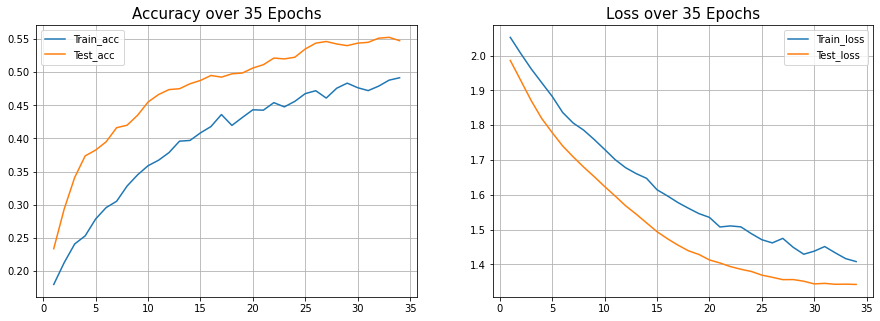

800/800 [==============================] - 0s 94us/step
Test loss: 1.553894350528717
Test accuracy: 0.4449999928474426
Test precision: 0.27031636238098145
Test Recall: 0.5389094352722168
Test F1 Score:  0.36003804776872805
[32, 32, 16]
Train on 6400 samples, validate on 800 samples
Epoch 1/35
6400/6400 [==============================] - 2s 291us/step - loss: 2.2363 - accuracy: 0.1287 - precision_9: 0.1226 - recall_9: 0.4549 - true_positives_9: 1503.6100 - true_negatives_9: 11863.5654 - false_positives_9: 10592.4346 - false_negatives_9: 1704.3900 - val_loss: 2.0592 - val_accuracy: 0.1650 - val_precision_9: 0.1255 - val_recall_9: 0.4876 - val_true_positives_9: 3320.1399 - val_true_negatives_9: 24512.9395 - val_false_positives_9: 23143.0605 - val_false_negatives_9: 3487.8601
Epoch 2/35
6400/6400 [==============================] - 2s 262us/step - loss: 2.1003 - accuracy: 0.1523 - precision_9: 0.1281 - recall_9: 0.5118 - true_positives_9: 5346.8301 - true_negatives_9: 36519.1758 - false_pos

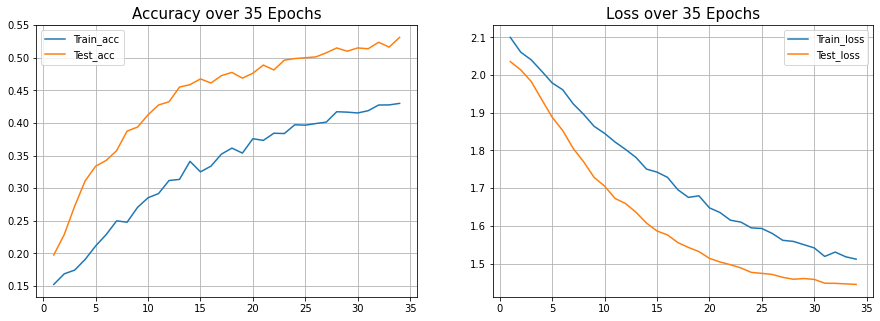

800/800 [==============================] - 0s 88us/step
Test loss: 1.6157105779647827
Test accuracy: 0.4037500023841858
Test precision: 0.2367580384016037
Test Recall: 0.6161150336265564
Test F1 Score:  0.3420677509357342
[32, 64, 32]
Train on 6400 samples, validate on 800 samples
Epoch 1/35
6400/6400 [==============================] - 2s 284us/step - loss: 2.1288 - accuracy: 0.1439 - precision_10: 0.1265 - recall_10: 0.5916 - true_positives_10: 1941.3375 - true_negatives_10: 9288.1523 - false_positives_10: 13167.8477 - false_negatives_10: 1266.6625 - val_loss: 2.0162 - val_accuracy: 0.1988 - val_precision_10: 0.1312 - val_recall_10: 0.6318 - val_true_positives_10: 4303.1401 - val_true_negatives_10: 19179.3008 - val_false_positives_10: 28476.6992 - val_false_negatives_10: 2504.8601
Epoch 2/35
6400/6400 [==============================] - 2s 251us/step - loss: 2.0530 - accuracy: 0.1750 - precision_10: 0.1345 - recall_10: 0.6546 - true_positives_10: 6824.9902 - true_negatives_10: 28996.52

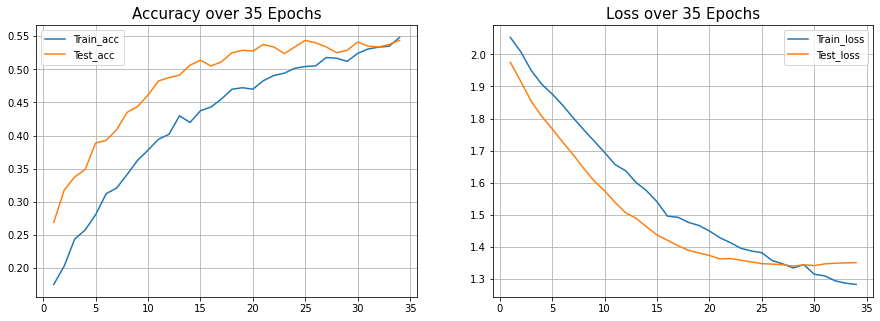

800/800 [==============================] - 0s 78us/step
Test loss: 1.6039004707336426
Test accuracy: 0.42875000834465027
Test precision: 0.2820419371128082
Test Recall: 0.6310629844665527
Test F1 Score:  0.3898483566845328
[128, 64, 64]
Train on 6400 samples, validate on 800 samples
Epoch 1/35
6400/6400 [==============================] - 2s 297us/step - loss: 2.1260 - accuracy: 0.1636 - precision_11: 0.1363 - recall_11: 0.6415 - true_positives_11: 2133.7524 - true_negatives_11: 9116.4229 - false_positives_11: 13339.5771 - false_negatives_11: 1074.2476 - val_loss: 1.9514 - val_accuracy: 0.3125 - val_precision_11: 0.1405 - val_recall_11: 0.7132 - val_true_positives_11: 4857.3398 - val_true_negatives_11: 17957.8809 - val_false_positives_11: 29698.1191 - val_false_negatives_11: 1950.6600
Epoch 2/35
6400/6400 [==============================] - 2s 267us/step - loss: 2.0014 - accuracy: 0.2031 - precision_11: 0.1433 - recall_11: 0.7399 - true_positives_11: 7715.3101 - true_negatives_11: 26839.

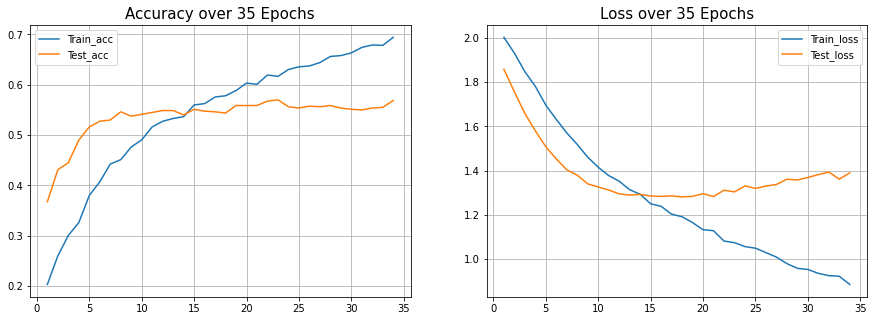

800/800 [==============================] - 0s 87us/step
Test loss: 1.8688022661209107
Test accuracy: 0.4412499964237213
Test precision: 0.36892154812812805
Test Recall: 0.5715051889419556
Test F1 Score:  0.4483934170663888
[64, 64, 32]
Train on 6400 samples, validate on 800 samples
Epoch 1/35
6400/6400 [==============================] - 2s 293us/step - loss: 2.1840 - accuracy: 0.1462 - precision_12: 0.1268 - recall_12: 0.4852 - true_positives_12: 1607.6825 - true_negatives_12: 11500.8877 - false_positives_12: 10955.1123 - false_negatives_12: 1600.3175 - val_loss: 2.0240 - val_accuracy: 0.2188 - val_precision_12: 0.1319 - val_recall_12: 0.5442 - val_true_positives_12: 3706.3601 - val_true_negatives_12: 23262.0801 - val_false_positives_12: 24393.9199 - val_false_negatives_12: 3101.6399
Epoch 2/35
6400/6400 [==============================] - 2s 259us/step - loss: 2.0502 - accuracy: 0.1859 - precision_12: 0.1364 - recall_12: 0.5806 - true_positives_12: 6067.9399 - true_negatives_12: 34542.

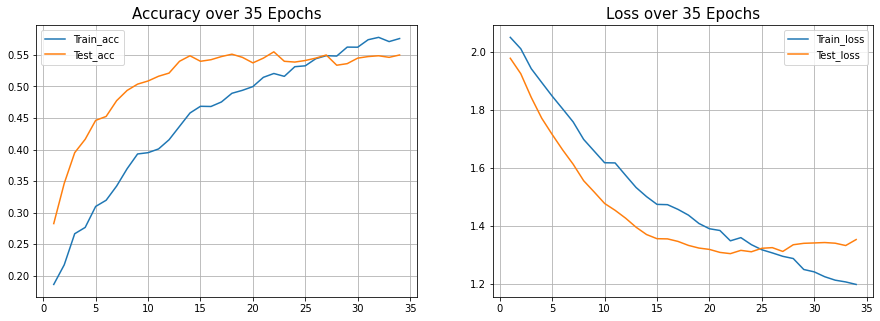

800/800 [==============================] - 0s 90us/step
Test loss: 1.6385115456581116
Test accuracy: 0.42250001430511475
Test precision: 0.3144422173500061
Test Recall: 0.5574043989181519
Test F1 Score:  0.4020695197664492
[32, 32, 32]
Train on 6400 samples, validate on 800 samples
Epoch 1/35
6400/6400 [==============================] - 2s 287us/step - loss: 2.1757 - accuracy: 0.1442 - precision_13: 0.1274 - recall_13: 0.5551 - true_positives_13: 1807.9399 - true_negatives_13: 10124.3896 - false_positives_13: 12331.6104 - false_negatives_13: 1400.0601 - val_loss: 2.0656 - val_accuracy: 0.1875 - val_precision_13: 0.1300 - val_recall_13: 0.5858 - val_true_positives_13: 3988.9399 - val_true_negatives_13: 20965.9609 - val_false_positives_13: 26690.0391 - val_false_negatives_13: 2819.0601
Epoch 2/35
6400/6400 [==============================] - 2s 259us/step - loss: 2.0786 - accuracy: 0.1642 - precision_13: 0.1328 - recall_13: 0.6098 - true_positives_13: 6362.2749 - true_negatives_13: 31371.

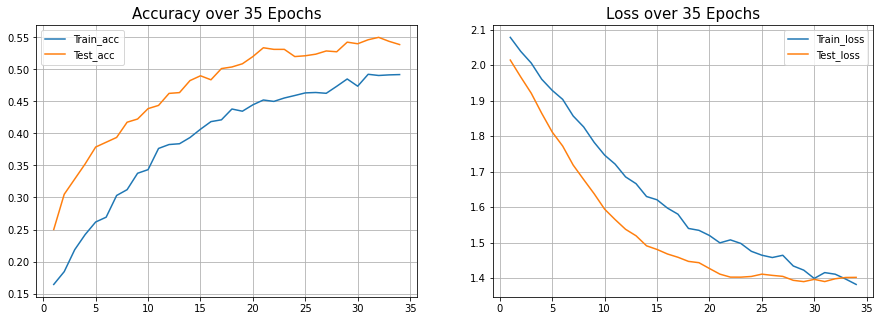

800/800 [==============================] - 0s 83us/step
Test loss: 1.5770605206489563
Test accuracy: 0.4325000047683716
Test precision: 0.26333072781562805
Test Recall: 0.6123347282409668
Test F1 Score:  0.36828345468970314
[16, 16, 16]
Train on 6400 samples, validate on 800 samples
Epoch 1/35
6400/6400 [==============================] - 2s 293us/step - loss: 2.1710 - accuracy: 0.1178 - precision_14: 0.1230 - recall_14: 0.6811 - true_positives_14: 2193.4600 - true_negatives_14: 6777.1025 - false_positives_14: 15678.8975 - false_negatives_14: 1014.5400 - val_loss: 2.0898 - val_accuracy: 0.1187 - val_precision_14: 0.1238 - val_recall_14: 0.7085 - val_true_positives_14: 4824.6401 - val_true_negatives_14: 13500.9199 - val_false_positives_14: 34155.0781 - val_false_negatives_14: 1983.3600
Epoch 2/35
6400/6400 [==============================] - 2s 262us/step - loss: 2.1155 - accuracy: 0.1241 - precision_14: 0.1241 - recall_14: 0.7230 - true_positives_14: 7532.1274 - true_negatives_14: 19710.

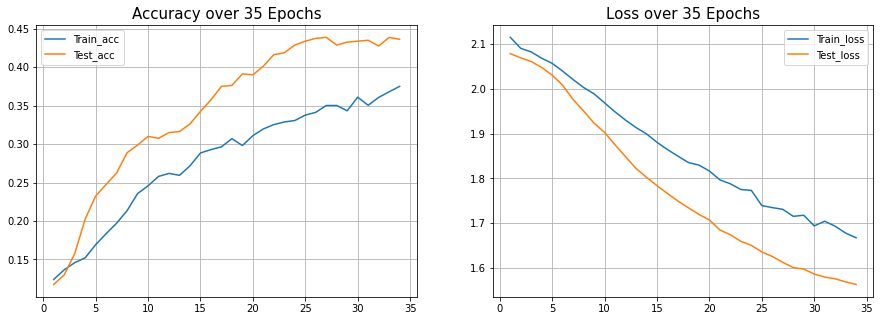

800/800 [==============================] - 0s 92us/step
Test loss: 1.7293263244628907
Test accuracy: 0.34375
Test precision: 0.18587073683738708
Test Recall: 0.692473828792572
Test F1 Score:  0.2930754645381547


In [ ]:
layers=[[128,128],[64,64],[32,32],[32,16],[16,16],[32,32,16],[32,64,32],
        [128,64,64],[64,64,32],[32,32,32],[16,16,16]]

for l in layers:
  print(l)
  model=create_model((df_features_train.shape[1],),8,lyrs=l, dr=0.5, droprate=0.00025)
  history = model.fit(df_features_train, df_features_train_y,
                      batch_size=16,
                      epochs=35,
                      validation_data=(df_features_valid, df_features_valid_y))

  plot_acc_loss(history, 35)
  x= model.evaluate(df_features_test.values,df_features_test_y)
  print('Test loss:' , x[0])
  print('Test accuracy:',x[1])
  print('Test precision:' , x[2])
  print('Test Recall:',x[3])
  print('Test F1 Score: ',2*(x[2]*x[3])/(x[2]+x[3]))

<h1>Echonest</h1>

<h3>SVM using Echo Nest Dataset</h3>

In [ ]:
df_tracks_echo=df_tracks[df_tracks.index.isin(df_echo.index.values.tolist())]
genres_echo=['Rock','Electronic','Hip-Hop','Folk','Old-Time / Historic',
             'Pop','Classical','Jazz']                    

df_tracks_echo_balanced_train=pd.DataFrame()
df_tracks_echo_balanced_valid=pd.DataFrame()
df_tracks_echo_balanced_test=pd.DataFrame()

for genre in genres_echo:
  df_tmp=df_tracks_echo[df_tracks_echo[('track','genre_top')]==genre]

  df_tracks_echo_balanced_train=pd.concat([df_tracks_echo_balanced_train,
                                            df_tmp[0:144]])
  
  df_tracks_echo_balanced_valid=pd.concat([df_tracks_echo_balanced_valid,
                                            df_tmp[144:192]])
  
  df_tracks_echo_balanced_test=pd.concat([df_tracks_echo_balanced_test,
                                            df_tmp[192:240]])
  
df_tracks_echo_balanced_train=df_tracks_echo_balanced_train.sort_index()
df_tracks_echo_balanced_valid=df_tracks_echo_balanced_valid.sort_index()
df_tracks_echo_balanced_test=df_tracks_echo_balanced_test.sort_index()

print(df_tracks_echo_balanced_train[('track','genre_top')].value_counts())
print(df_tracks_echo_balanced_valid[('track','genre_top')].value_counts())
print(df_tracks_echo_balanced_test[('track','genre_top')].value_counts())

df_cln_echo=pd.merge(df_echo.xs('temporal_features',level=1,axis=1), 
                       df_echo.xs('audio_features',level=1,axis=1), 
                       left_index=True, 
                       right_index=True)

indexes=df_cln_echo.index.values.tolist()
scaler=preprocessing.StandardScaler(copy=False)
df_cln_echo=scaler.fit_transform(df_cln_echo)
df_cln_echo=pd.DataFrame(data=df_cln_echo,index=indexes)

df_echo_train=df_cln_echo[df_cln_echo.index.isin(df_tracks_echo_balanced_train.index.values.tolist())]
df_echo_valid=df_cln_echo[df_cln_echo.index.isin(df_tracks_echo_balanced_valid.index.values.tolist())]
df_echo_test=df_cln_echo[df_cln_echo.index.isin(df_tracks_echo_balanced_test.index.values.tolist())]

df_echo_train=df_echo_train.sort_index()
df_echo_valid=df_echo_valid.sort_index()
df_echo_test=df_echo_test.sort_index()

df_echo_train_y=df_tracks_echo_balanced_train[('track','genre_top')]
df_echo_valid_y=df_tracks_echo_balanced_valid[('track','genre_top')]
df_echo_test_y=df_tracks_echo_balanced_test[('track','genre_top')]

print(len(df_echo_train))
print(len(df_echo_train_y))


le=LabelEncoder()
df_echo_train_y=le.fit_transform(df_echo_train_y)
df_echo_valid_y=le.fit_transform(df_echo_valid_y)
df_echo_test_y=le.fit_transform(df_echo_test_y)

#train 
clf_svc_echo = SVC()
clf_svc_echo.fit(df_echo_train, df_echo_train_y)

#test
predictions=clf_svc_echo.predict(df_echo_test)
labels = [0,1,2,3,4,5,6,7]
target_names = le.inverse_transform(labels)
print(classification_report(df_echo_test_y, predictions, target_names=target_names))

df_echo_train_y = to_categorical(df_echo_train_y)
df_echo_valid_y = to_categorical(df_echo_valid_y)
df_echo_test_y = to_categorical(df_echo_test_y)

Hip-Hop                144
Electronic             144
Pop                    144
Folk                   144
Classical              144
Rock                   144
Jazz                   144
Old-Time / Historic    144
Name: (track, genre_top), dtype: int64
Classical              48
Folk                   48
Hip-Hop                48
Rock                   48
Pop                    48
Electronic             48
Jazz                   48
Old-Time / Historic    48
Name: (track, genre_top), dtype: int64
Classical              48
Folk                   48
Hip-Hop                48
Rock                   48
Pop                    48
Electronic             48
Jazz                   48
Old-Time / Historic    48
Name: (track, genre_top), dtype: int64
1152
1152
                     precision    recall  f1-score   support

          Classical       0.87      0.94      0.90        48
         Electronic       0.67      0.46      0.54        48
               Folk       0.41      0.69      0.51       

<h3>Neural Network using Echo Nest Dataset</h3>

[128, 128]
Train on 1152 samples, validate on 384 samples
Epoch 1/35
1152/1152 [==============================] - 1s 447us/step - loss: 2.0759 - accuracy: 0.1840 - precision_17: 0.1292 - recall_17: 0.4222 - true_positives_17: 269.2222 - true_negatives_17: 2446.2361 - false_positives_17: 1641.7639 - false_negatives_17: 314.7778 - val_loss: 1.8715 - val_accuracy: 0.3698 - val_precision_17: 0.1660 - val_recall_17: 0.5394 - val_true_positives_17: 731.2500 - val_true_negatives_17: 5803.8335 - val_false_positives_17: 3660.1667 - val_false_negatives_17: 620.7500
Epoch 2/35
1152/1152 [==============================] - 0s 270us/step - loss: 1.8026 - accuracy: 0.3828 - precision_17: 0.1860 - recall_17: 0.5825 - true_positives_17: 1239.9028 - true_negatives_17: 9453.4863 - false_positives_17: 5386.5137 - false_negatives_17: 880.0972 - val_loss: 1.6784 - val_accuracy: 0.4609 - val_precision_17: 0.2045 - val_recall_17: 0.6119 - val_true_positives_17: 1767.6666 - val_true_negatives_17: 13344.9170 - 

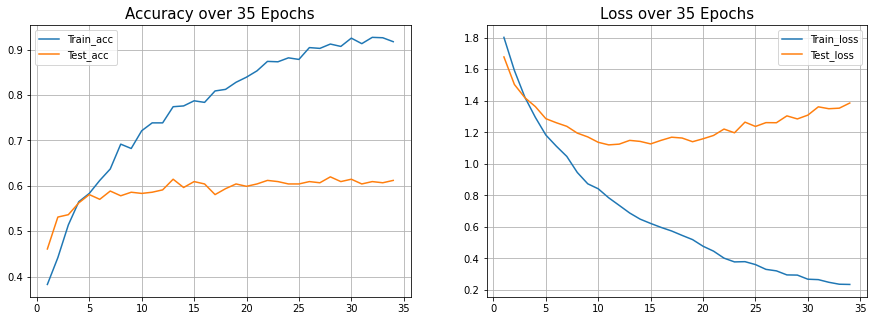

384/384 [==============================] - 0s 87us/step
Test loss: 1.3845145027929295
Test accuracy: 0.6197916865348816
Test precision: 0.5700727105140686
Test Recall: 0.41567447781562805
Test F1 Score:  0.4807818456198712
[64, 64]
Train on 1152 samples, validate on 384 samples
Epoch 1/35
1152/1152 [==============================] - 0s 419us/step - loss: 2.1490 - accuracy: 0.1970 - precision_18: 0.1386 - recall_18: 0.5200 - true_positives_18: 315.4028 - true_negatives_18: 2209.5693 - false_positives_18: 1878.4305 - false_negatives_18: 268.5972 - val_loss: 1.9569 - val_accuracy: 0.2135 - val_precision_18: 0.1533 - val_recall_18: 0.5832 - val_true_positives_18: 788.7917 - val_true_negatives_18: 5107.9165 - val_false_positives_18: 4356.0835 - val_false_negatives_18: 563.2083
Epoch 2/35
1152/1152 [==============================] - 0s 272us/step - loss: 1.9482 - accuracy: 0.2405 - precision_18: 0.1615 - recall_18: 0.6149 - true_positives_18: 1307.6945 - true_negatives_18: 8073.7222 - false_

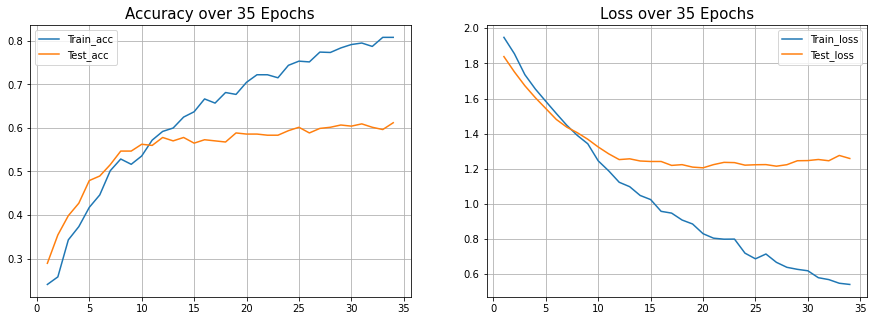

384/384 [==============================] - 0s 88us/step
Test loss: 1.232212433940731
Test accuracy: 0.6145833134651184
Test precision: 0.41572141647338867
Test Recall: 0.6211079359054565
Test F1 Score:  0.49807207001819714
[32, 32]
Train on 1152 samples, validate on 384 samples
Epoch 1/35
1152/1152 [==============================] - 1s 461us/step - loss: 2.1476 - accuracy: 0.1649 - precision_19: 0.1302 - recall_19: 0.5283 - true_positives_19: 316.3889 - true_negatives_19: 2014.5555 - false_positives_19: 2073.4443 - false_negatives_19: 267.6111 - val_loss: 2.0260 - val_accuracy: 0.2135 - val_precision_19: 0.1374 - val_recall_19: 0.5691 - val_true_positives_19: 770.9167 - val_true_negatives_19: 4633.8335 - val_false_positives_19: 4830.1665 - val_false_negatives_19: 581.0833
Epoch 2/35
1152/1152 [==============================] - 0s 299us/step - loss: 2.0128 - accuracy: 0.2083 - precision_19: 0.1449 - recall_19: 0.6113 - true_positives_19: 1299.8055 - true_negatives_19: 7190.4443 - false_

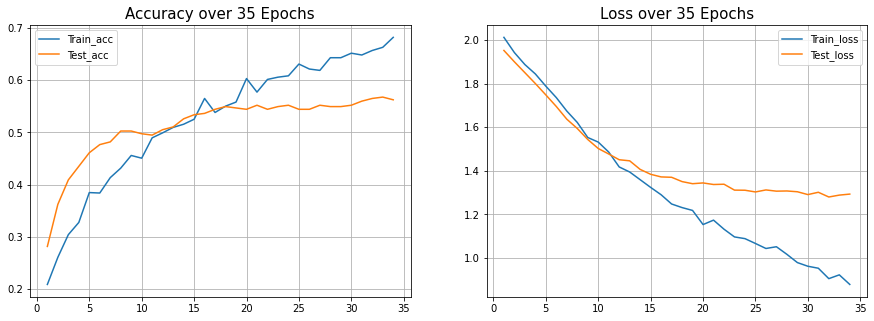

384/384 [==============================] - 0s 91us/step
Test loss: 1.1296700267121196
Test accuracy: 0.5807291865348816
Test precision: 0.3186013996601105
Test Recall: 0.7097281813621521
Test F1 Score:  0.43978194565874507
[32, 16]
Train on 1152 samples, validate on 384 samples
Epoch 1/35
1152/1152 [==============================] - 1s 454us/step - loss: 2.1756 - accuracy: 0.1302 - precision_20: 0.1341 - recall_20: 0.6434 - true_positives_20: 380.2500 - true_negatives_20: 1650.8195 - false_positives_20: 2437.1807 - false_negatives_20: 203.7500 - val_loss: 2.0877 - val_accuracy: 0.1719 - val_precision_20: 0.1402 - val_recall_20: 0.6849 - val_true_positives_20: 926.3750 - val_true_negatives_20: 3784.2500 - val_false_positives_20: 5679.7500 - val_false_negatives_20: 425.6250
Epoch 2/35
1152/1152 [==============================] - 0s 288us/step - loss: 2.0444 - accuracy: 0.1641 - precision_20: 0.1403 - recall_20: 0.6882 - true_positives_20: 1460.7639 - true_negatives_20: 5905.4722 - false_

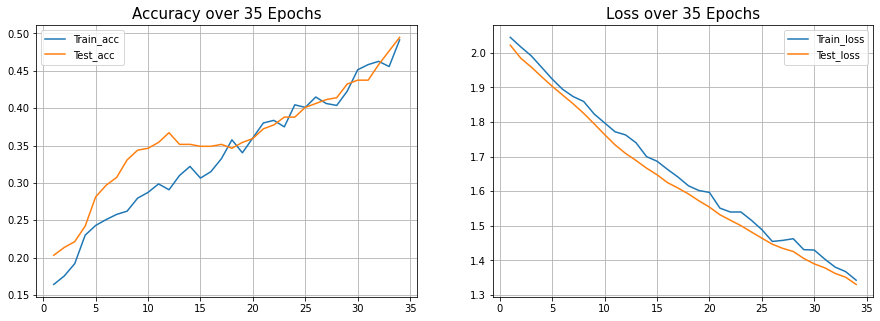

384/384 [==============================] - 0s 92us/step
Test loss: 1.3105841775735219
Test accuracy: 0.5052083134651184
Test precision: 0.21511583030223846
Test Recall: 0.801959753036499
Test F1 Score:  0.33923582665727736
[16, 16]
Train on 1152 samples, validate on 384 samples
Epoch 1/35
1152/1152 [==============================] - 0s 427us/step - loss: 2.1656 - accuracy: 0.1285 - precision_21: 0.1173 - recall_21: 0.5165 - true_positives_21: 311.4861 - true_negatives_21: 1825.9166 - false_positives_21: 2262.0833 - false_negatives_21: 272.5139 - val_loss: 2.0845 - val_accuracy: 0.1276 - val_precision_21: 0.1287 - val_recall_21: 0.5798 - val_true_positives_21: 784.3333 - val_true_negatives_21: 4154.1250 - val_false_positives_21: 5309.8750 - val_false_negatives_21: 567.6667
Epoch 2/35
1152/1152 [==============================] - 0s 291us/step - loss: 2.0778 - accuracy: 0.1484 - precision_21: 0.1320 - recall_21: 0.5970 - true_positives_21: 1268.3750 - true_negatives_21: 6514.4028 - false_

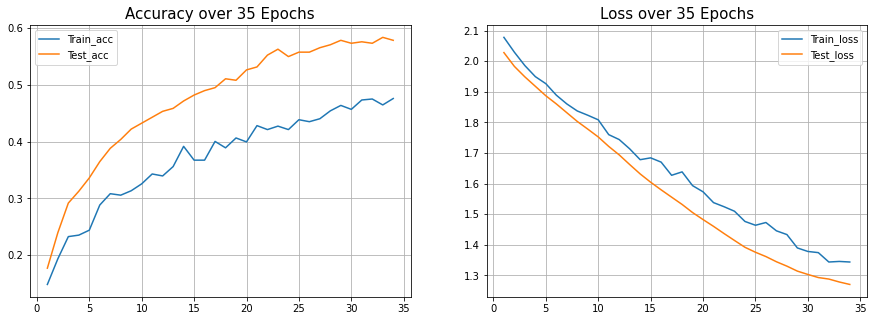

384/384 [==============================] - 0s 84us/step
Test loss: 1.2872427167991798
Test accuracy: 0.5546875
Test precision: 0.22912843525409698
Test Recall: 0.7646756172180176
Test F1 Score:  0.3526025622742999
[32, 32, 16]
Train on 1152 samples, validate on 384 samples
Epoch 1/35
1152/1152 [==============================] - 1s 452us/step - loss: 2.2208 - accuracy: 0.1432 - precision_22: 0.1279 - recall_22: 0.3617 - true_positives_22: 213.5556 - true_negatives_22: 2624.7500 - false_positives_22: 1463.2500 - false_negatives_22: 370.4445 - val_loss: 2.0848 - val_accuracy: 0.1250 - val_precision_22: 0.1265 - val_recall_22: 0.3531 - val_true_positives_22: 476.8750 - val_true_negatives_22: 6171.2915 - val_false_positives_22: 3292.7083 - val_false_negatives_22: 875.1250
Epoch 2/35
1152/1152 [==============================] - 0s 313us/step - loss: 2.1625 - accuracy: 0.1458 - precision_22: 0.1286 - recall_22: 0.3587 - true_positives_22: 763.5278 - true_negatives_22: 9678.0977 - false_positi

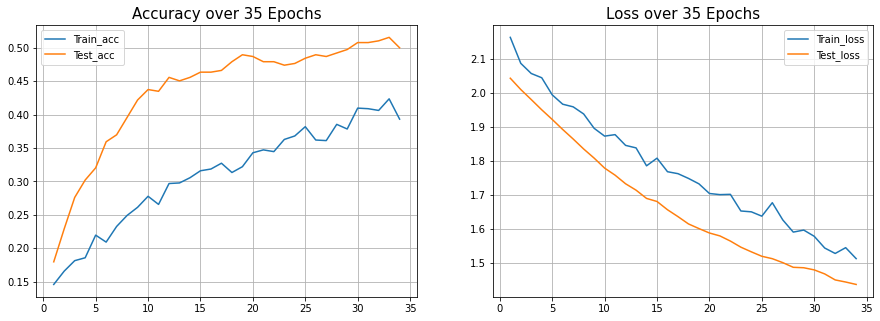

384/384 [==============================] - 0s 81us/step
Test loss: 1.4382633455097675
Test accuracy: 0.5052083134651184
Test precision: 0.23031140863895416
Test Recall: 0.6182577013969421
Test F1 Score:  0.33560449096382533
[32, 64, 32]
Train on 1152 samples, validate on 384 samples
Epoch 1/35
1152/1152 [==============================] - 1s 483us/step - loss: 2.1446 - accuracy: 0.1450 - precision_23: 0.1307 - recall_23: 0.5657 - true_positives_23: 327.3889 - true_negatives_23: 1869.2361 - false_positives_23: 2218.7639 - false_negatives_23: 256.6111 - val_loss: 2.0543 - val_accuracy: 0.1719 - val_precision_23: 0.1282 - val_recall_23: 0.5813 - val_true_positives_23: 786.9167 - val_true_negatives_23: 4114.1665 - val_false_positives_23: 5349.8335 - val_false_negatives_23: 565.0833
Epoch 2/35
1152/1152 [==============================] - 0s 305us/step - loss: 2.0687 - accuracy: 0.1710 - precision_23: 0.1311 - recall_23: 0.6009 - true_positives_23: 1275.5416 - true_negatives_23: 6396.6943 - f

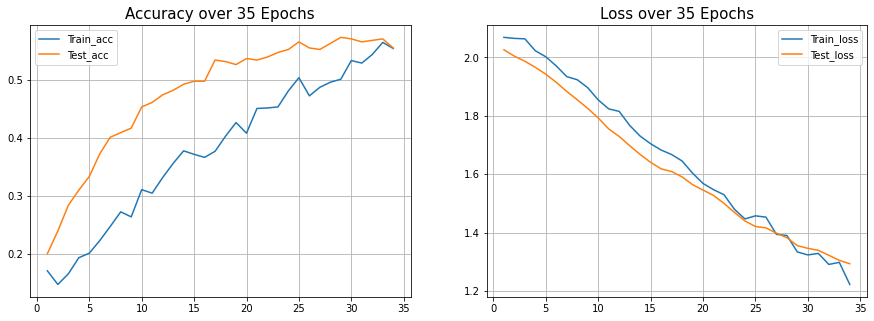

384/384 [==============================] - 0s 88us/step
Test loss: 1.2402062732726336
Test accuracy: 0.5520833134651184
Test precision: 0.22540326416492462
Test Recall: 0.7342408299446106
Test F1 Score:  0.34492012355111334
[128, 64, 64]
Train on 1152 samples, validate on 384 samples
Epoch 1/35
1152/1152 [==============================] - 1s 491us/step - loss: 2.1250 - accuracy: 0.1415 - precision_24: 0.1360 - recall_24: 0.5649 - true_positives_24: 327.4305 - true_negatives_24: 1993.0278 - false_positives_24: 2094.9722 - false_negatives_24: 256.5695 - val_loss: 2.0052 - val_accuracy: 0.1745 - val_precision_24: 0.1446 - val_recall_24: 0.6203 - val_true_positives_24: 840.1250 - val_true_negatives_24: 4501.4165 - val_false_positives_24: 4962.5835 - val_false_negatives_24: 511.8750
Epoch 2/35
1152/1152 [==============================] - 0s 296us/step - loss: 2.0217 - accuracy: 0.1866 - precision_24: 0.1472 - recall_24: 0.6344 - true_positives_24: 1346.1111 - true_negatives_24: 7051.7637 - 

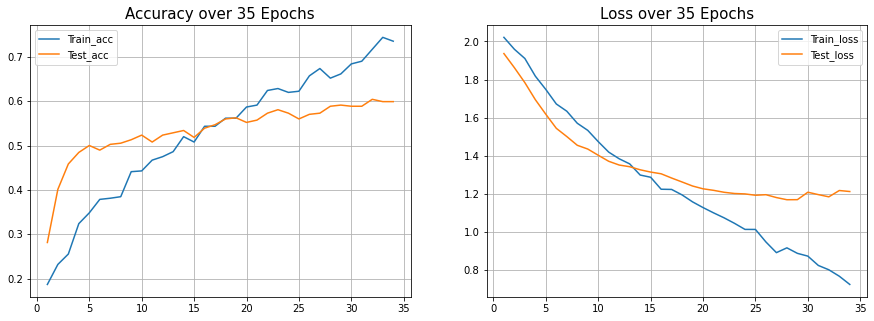

384/384 [==============================] - 0s 87us/step
Test loss: 1.1406604133856793
Test accuracy: 0.6145833134651184
Test precision: 0.32760515809059143
Test Recall: 0.6956023573875427
Test F1 Score:  0.4454285505392261
[64, 64, 32]
Train on 1152 samples, validate on 384 samples
Epoch 1/35
1152/1152 [==============================] - 1s 449us/step - loss: 2.1381 - accuracy: 0.1337 - precision_25: 0.1217 - recall_25: 0.5242 - true_positives_25: 312.7222 - true_negatives_25: 1874.5834 - false_positives_25: 2213.4167 - false_negatives_25: 271.2778 - val_loss: 2.1073 - val_accuracy: 0.1120 - val_precision_25: 0.1234 - val_recall_25: 0.5381 - val_true_positives_25: 727.9583 - val_true_negatives_25: 4293.8335 - val_false_positives_25: 5170.1665 - val_false_negatives_25: 624.0417
Epoch 2/35
1152/1152 [==============================] - 0s 307us/step - loss: 2.0983 - accuracy: 0.1493 - precision_25: 0.1277 - recall_25: 0.5561 - true_positives_25: 1180.5555 - true_negatives_25: 6793.9722 - fa

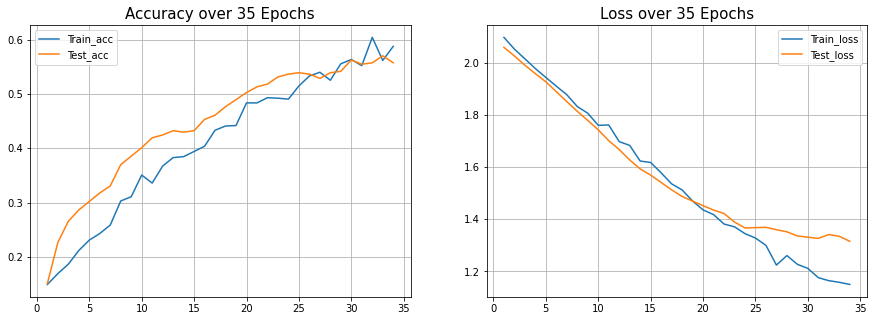

384/384 [==============================] - 0s 112us/step
Test loss: 1.217299053600679
Test accuracy: 0.5390625
Test precision: 0.25482627749443054
Test Recall: 0.6910621523857117
Test F1 Score:  0.37235003674176315
[32, 32, 32]
Train on 1152 samples, validate on 384 samples
Epoch 1/35
1152/1152 [==============================] - 1s 493us/step - loss: 2.1458 - accuracy: 0.1224 - precision_26: 0.1334 - recall_26: 0.6594 - true_positives_26: 388.2361 - true_negatives_26: 1576.7500 - false_positives_26: 2511.2500 - false_negatives_26: 195.7639 - val_loss: 2.0616 - val_accuracy: 0.1432 - val_precision_26: 0.1322 - val_recall_26: 0.6681 - val_true_positives_26: 904.5000 - val_true_negatives_26: 3532.5833 - val_false_positives_26: 5931.4165 - val_false_negatives_26: 447.5000
Epoch 2/35
1152/1152 [==============================] - 0s 326us/step - loss: 2.1176 - accuracy: 0.1293 - precision_26: 0.1332 - recall_26: 0.6814 - true_positives_26: 1444.4445 - true_negatives_26: 5437.6113 - false_posi

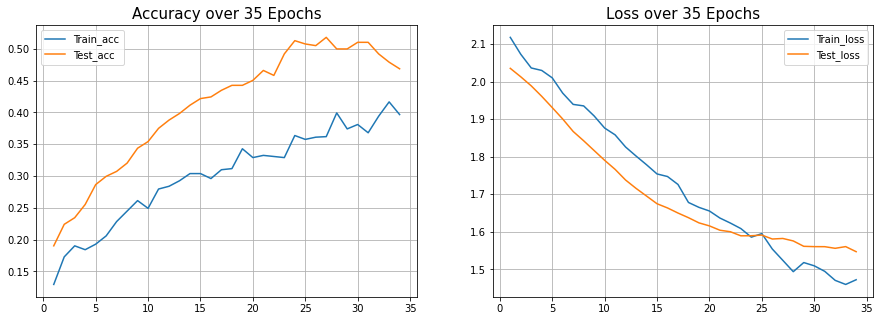

384/384 [==============================] - 0s 114us/step
Test loss: 1.4424170056978862
Test accuracy: 0.4270833432674408
Test precision: 0.19990849494934082
Test Recall: 0.8009417653083801
Test F1 Score:  0.31995807805182863
[16, 16, 16]
Train on 1152 samples, validate on 384 samples
Epoch 1/35
1152/1152 [==============================] - 1s 445us/step - loss: 2.1248 - accuracy: 0.1215 - precision_27: 0.1294 - recall_27: 0.6118 - true_positives_27: 350.5139 - true_negatives_27: 1673.6528 - false_positives_27: 2414.3472 - false_negatives_27: 233.4861 - val_loss: 2.0599 - val_accuracy: 0.1224 - val_precision_27: 0.1245 - val_recall_27: 0.5894 - val_true_positives_27: 797.3750 - val_true_negatives_27: 3858.5417 - val_false_positives_27: 5605.4585 - val_false_negatives_27: 554.6250
Epoch 2/35
1152/1152 [==============================] - 0s 291us/step - loss: 2.0886 - accuracy: 0.1389 - precision_27: 0.1291 - recall_27: 0.6150 - true_positives_27: 1305.3611 - true_negatives_27: 6041.4585 - 

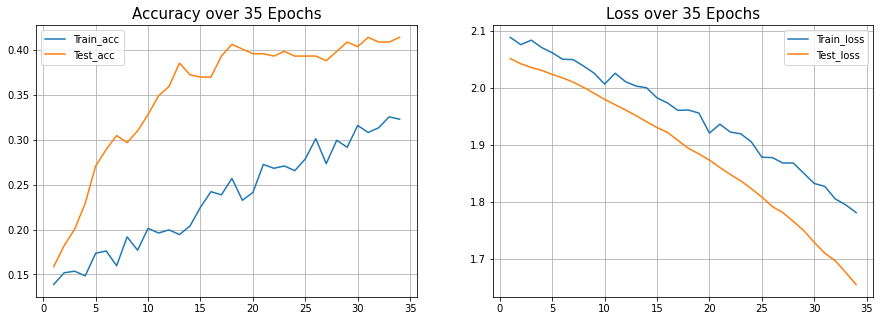

384/384 [==============================] - 0s 79us/step
Test loss: 1.6617443064848583
Test accuracy: 0.4088541567325592
Test precision: 0.16539506614208221
Test Recall: 0.7425617575645447
Test F1 Score:  0.27053280023952375


In [ ]:
layers=[[128,128],[64,64],[32,32],[32,16],[16,16],[32,32,16],[32,64,32],
        [128,64,64],[64,64,32],[32,32,32],[16,16,16]]

for l in layers:
  print(l)
  model=create_model((df_echo_train.shape[1],),8,lyrs=l, dr=0.5, droprate=0.00025)
  history = model.fit(df_echo_train, df_echo_train_y,
                      batch_size=16,
                      epochs=35,
                      validation_data=(df_echo_valid, df_echo_valid_y))

  plot_acc_loss(history, 35)
  x= model.evaluate(df_echo_test,df_echo_test_y)
  print('Test loss:' , x[0])
  print('Test accuracy:',x[1])
  print('Test precision:' , x[2])
  print('Test Recall:',x[3])
  print('Test F1 Score: ',2*(x[2]*x[3])/(x[2]+x[3]))

[32, 16]
Train on 1152 samples, validate on 384 samples
Epoch 1/60
1152/1152 [==============================] - 1s 447us/step - loss: 2.1070 - accuracy: 0.1328 - precision_34: 0.1332 - recall_34: 0.5335 - true_positives_34: 308.4305 - true_negatives_34: 2040.8611 - false_positives_34: 2047.1389 - false_negatives_34: 275.5695 - val_loss: 2.0311 - val_accuracy: 0.2318 - val_precision_34: 0.1344 - val_recall_34: 0.5490 - val_true_positives_34: 742.7083 - val_true_negatives_34: 4681.0000 - val_false_positives_34: 4783.0000 - val_false_negatives_34: 609.2917
Epoch 2/60
1152/1152 [==============================] - 0s 274us/step - loss: 2.0490 - accuracy: 0.1675 - precision_34: 0.1366 - recall_34: 0.5654 - true_positives_34: 1200.9028 - true_negatives_34: 7264.2778 - false_positives_34: 7575.7222 - false_negatives_34: 919.0972 - val_loss: 1.9997 - val_accuracy: 0.2422 - val_precision_34: 0.1415 - val_recall_34: 0.5854 - val_true_positives_34: 1691.0416 - val_true_negatives_34: 9959.8330 - val

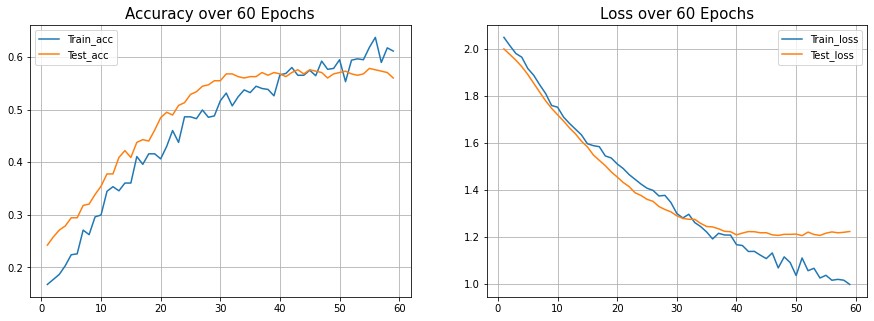

384/384 [==============================] - 0s 85us/step
Test loss: 1.1572285288323958
Test accuracy: 0.5911458134651184
Test precision: 0.3049156665802002
Test Recall: 0.6691758632659912
Test F1 Score:  0.41893846349192415
[16, 16]
Train on 1152 samples, validate on 384 samples
Epoch 1/60
1152/1152 [==============================] - 1s 468us/step - loss: 2.1115 - accuracy: 0.1328 - precision_35: 0.1274 - recall_35: 0.5857 - true_positives_35: 342.7639 - true_negatives_35: 1747.1805 - false_positives_35: 2340.8193 - false_negatives_35: 241.2361 - val_loss: 2.0553 - val_accuracy: 0.1771 - val_precision_35: 0.1310 - val_recall_35: 0.6069 - val_true_positives_35: 821.3333 - val_true_negatives_35: 4020.5833 - val_false_positives_35: 5443.4165 - val_false_negatives_35: 530.6667
Epoch 2/60
1152/1152 [==============================] - 0s 282us/step - loss: 2.0638 - accuracy: 0.1606 - precision_35: 0.1350 - recall_35: 0.6243 - true_positives_35: 1325.5278 - true_negatives_35: 6360.7500 - false_

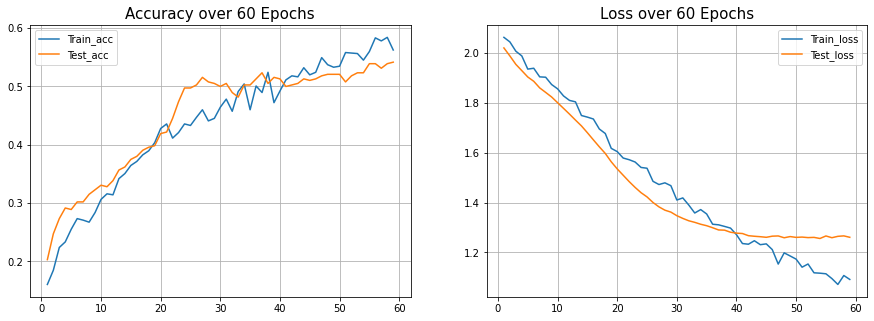

384/384 [==============================] - 0s 80us/step
Test loss: 1.2066666595637798
Test accuracy: 0.5885416865348816
Test precision: 0.26994797587394714
Test Recall: 0.728888988494873
Test F1 Score:  0.39398242976587594
[32, 32]
Train on 1152 samples, validate on 384 samples
Epoch 1/60
1152/1152 [==============================] - 1s 437us/step - loss: 2.1467 - accuracy: 0.1319 - precision_36: 0.1322 - recall_36: 0.4640 - true_positives_36: 278.1667 - true_negatives_36: 2305.0557 - false_positives_36: 1782.9445 - false_negatives_36: 305.8333 - val_loss: 1.9888 - val_accuracy: 0.2005 - val_precision_36: 0.1416 - val_recall_36: 0.5041 - val_true_positives_36: 683.1667 - val_true_negatives_36: 5334.3335 - val_false_positives_36: 4129.6665 - val_false_negatives_36: 668.8333
Epoch 2/60
1152/1152 [==============================] - 0s 278us/step - loss: 2.0473 - accuracy: 0.2031 - precision_36: 0.1524 - recall_36: 0.5426 - true_positives_36: 1151.6389 - true_negatives_36: 8443.8613 - false_

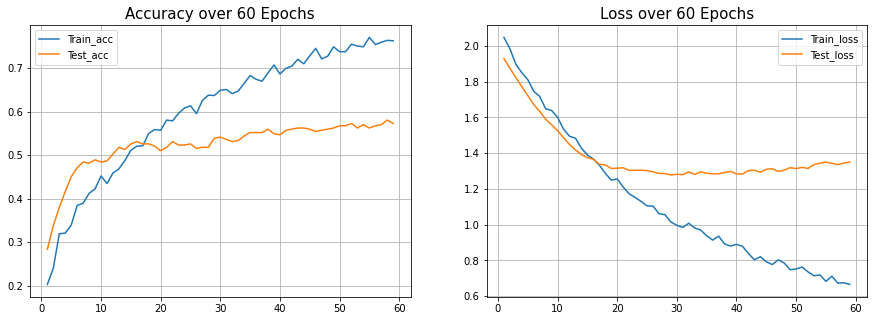

384/384 [==============================] - 0s 92us/step
Test loss: 1.1632864830705028
Test accuracy: 0.5963541865348816
Test precision: 0.4043583571910858
Test Recall: 0.5188162326812744
Test F1 Score:  0.4544918844875786
[64, 32]
Train on 1152 samples, validate on 384 samples
Epoch 1/60
1152/1152 [==============================] - 0s 433us/step - loss: 2.1343 - accuracy: 0.1545 - precision_37: 0.1301 - recall_37: 0.6422 - true_positives_37: 381.5000 - true_negatives_37: 1587.4028 - false_positives_37: 2500.5972 - false_negatives_37: 202.5000 - val_loss: 1.9706 - val_accuracy: 0.2552 - val_precision_37: 0.1386 - val_recall_37: 0.6847 - val_true_positives_37: 927.7083 - val_true_negatives_37: 3707.9583 - val_false_positives_37: 5756.0415 - val_false_negatives_37: 424.2917
Epoch 2/60
1152/1152 [==============================] - 0s 282us/step - loss: 2.0061 - accuracy: 0.2370 - precision_37: 0.1435 - recall_37: 0.7122 - true_positives_37: 1511.9861 - true_negatives_37: 5840.5137 - false_p

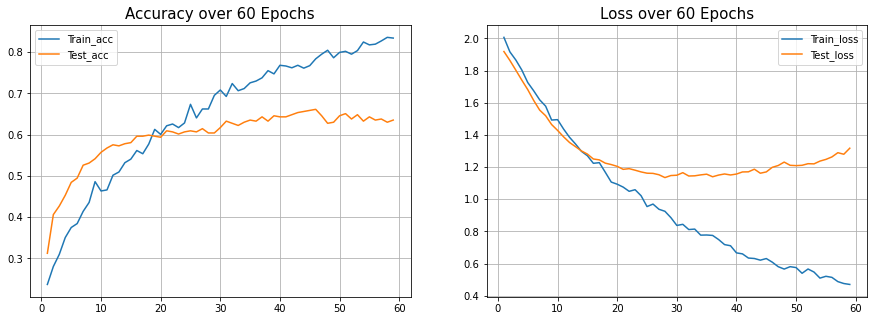

384/384 [==============================] - 0s 82us/step
Test loss: 1.3703858492275078
Test accuracy: 0.6119791865348816
Test precision: 0.41526880860328674
Test Recall: 0.6458669900894165
Test F1 Score:  0.5055119539290821
[64, 64]
Train on 1152 samples, validate on 384 samples
Epoch 1/60
1152/1152 [==============================] - 0s 413us/step - loss: 2.1479 - accuracy: 0.1354 - precision_38: 0.1283 - recall_38: 0.3701 - true_positives_38: 225.4167 - true_negatives_38: 2610.4861 - false_positives_38: 1477.5139 - false_negatives_38: 358.5833 - val_loss: 2.0301 - val_accuracy: 0.2188 - val_precision_38: 0.1433 - val_recall_38: 0.4145 - val_true_positives_38: 560.8333 - val_true_negatives_38: 6115.0415 - val_false_positives_38: 3348.9583 - val_false_negatives_38: 791.1667
Epoch 2/60
1152/1152 [==============================] - 0s 274us/step - loss: 1.9704 - accuracy: 0.2422 - precision_38: 0.1554 - recall_38: 0.4526 - true_positives_38: 965.7361 - true_negatives_38: 9625.2637 - false_p

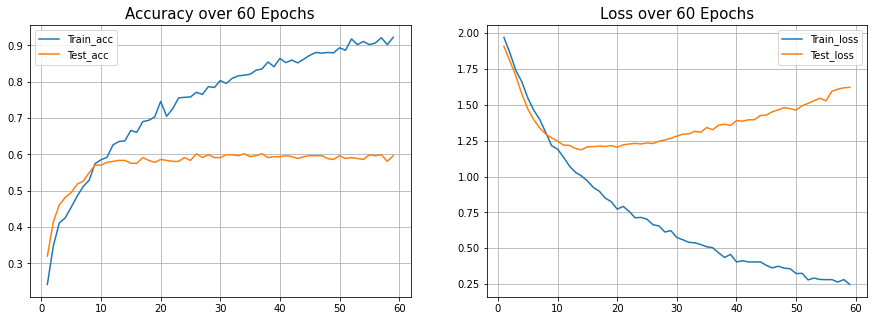

384/384 [==============================] - 0s 95us/step
Test loss: 1.6933241073663037
Test accuracy: 0.5911458134651184
Test precision: 0.5776426196098328
Test Recall: 0.4868057668209076
Test F1 Score:  0.5283483200731012


In [ ]:
layers=[[32,16],[16,16],[32,32],[64,32],[64,64]]

for l in layers:
  print(l)
  model=create_model((df_echo_train.shape[1],),8,lyrs=l, dr=0.5, droprate=0.00025)
  history = model.fit(df_echo_train, df_echo_train_y,
                      batch_size=16,
                      epochs=60,
                      validation_data=(df_echo_valid, df_echo_valid_y))

  plot_acc_loss(history, 60)
  x= model.evaluate(df_echo_test,df_echo_test_y)
  print('Test loss:' , x[0])
  print('Test accuracy:',x[1])
  print('Test precision:' , x[2])
  print('Test Recall:',x[3])
  print('Test F1 Score: ',2*(x[2]*x[3])/(x[2]+x[3]))

<h3>SVM with PCA using Echo Nest Dataset</h3>

In [ ]:
genres_echo=['Rock','Electronic','Hip-Hop','Folk','Old-Time / Historic',
             'Pop','Classical','Jazz']                    

df_tracks_echo_balanced_train=pd.DataFrame()
df_tracks_echo_balanced_valid=pd.DataFrame()
df_tracks_echo_balanced_test=pd.DataFrame()

for genre in genres_echo:
  df_tmp=df_tracks_echo[df_tracks_echo[('track','genre_top')]==genre]

  df_tracks_echo_balanced_train=pd.concat([df_tracks_echo_balanced_train,
                                            df_tmp[0:144]])
  
  df_tracks_echo_balanced_valid=pd.concat([df_tracks_echo_balanced_valid,
                                            df_tmp[144:192]])
  
  df_tracks_echo_balanced_test=pd.concat([df_tracks_echo_balanced_test,
                                            df_tmp[192:240]])
  
df_tracks_echo_balanced_train=df_tracks_echo_balanced_train.sort_index()
df_tracks_echo_balanced_valid=df_tracks_echo_balanced_valid.sort_index()
df_tracks_echo_balanced_test=df_tracks_echo_balanced_test.sort_index()

print(df_tracks_echo_balanced_train[('track','genre_top')].value_counts())
print(df_tracks_echo_balanced_valid[('track','genre_top')].value_counts())
print(df_tracks_echo_balanced_test[('track','genre_top')].value_counts())

df_cln_echo=pd.merge(df_echo.xs('temporal_features',level=1,axis=1), 
                       df_echo.xs('audio_features',level=1,axis=1), 
                       left_index=True, 
                       right_index=True)

indexes=df_cln_echo.index.values.tolist()
scaler=preprocessing.StandardScaler(copy=False)
df_cln_echo=scaler.fit_transform(df_cln_echo)

pca=PCA(0.90)
principal_components=pca.fit_transform(df_cln_echo)
df_cln_echo=pd.DataFrame(data=principal_components,index=indexes)

df_echo_train=df_cln_echo[df_cln_echo.index.isin(df_tracks_echo_balanced_train.index.values.tolist())]
df_echo_valid=df_cln_echo[df_cln_echo.index.isin(df_tracks_echo_balanced_valid.index.values.tolist())]
df_echo_test=df_cln_echo[df_cln_echo.index.isin(df_tracks_echo_balanced_test.index.values.tolist())]

df_echo_train=df_echo_train.sort_index()
df_echo_valid=df_echo_valid.sort_index()
df_echo_test=df_echo_test.sort_index()

df_echo_train_y=df_tracks_echo_balanced_train[('track','genre_top')]
df_echo_valid_y=df_tracks_echo_balanced_valid[('track','genre_top')]
df_echo_test_y=df_tracks_echo_balanced_test[('track','genre_top')]

print(len(df_echo_train))
print(len(df_echo_train_y))

le=LabelEncoder()
df_echo_train_y=le.fit_transform(df_echo_train_y)
df_echo_valid_y=le.fit_transform(df_echo_valid_y)
df_echo_test_y=le.fit_transform(df_echo_test_y)

#train 
clf_svc_echo = SVC()
clf_svc_echo.fit(df_echo_train, df_echo_train_y)

#test
predictions=clf_svc_echo.predict(df_echo_test)
labels = [0,1,2,3,4,5,6,7]
target_names = le.inverse_transform(labels)
print(classification_report(df_echo_test_y, predictions, target_names=target_names))

df_echo_train_y = to_categorical(df_echo_train_y)
df_echo_valid_y = to_categorical(df_echo_valid_y)
df_echo_test_y = to_categorical(df_echo_test_y)

Jazz                   144
Rock                   144
Pop                    144
Old-Time / Historic    144
Folk                   144
Hip-Hop                144
Electronic             144
Classical              144
Name: (track, genre_top), dtype: int64
Old-Time / Historic    48
Folk                   48
Hip-Hop                48
Jazz                   48
Rock                   48
Electronic             48
Pop                    48
Classical              48
Name: (track, genre_top), dtype: int64
Old-Time / Historic    48
Folk                   48
Hip-Hop                48
Jazz                   48
Rock                   48
Electronic             48
Pop                    48
Classical              48
Name: (track, genre_top), dtype: int64
1152
1152
                     precision    recall  f1-score   support

          Classical       0.83      0.92      0.87        48
         Electronic       0.65      0.46      0.54        48
               Folk       0.40      0.71      0.51       

<h3>Neural Network with PCA using Echo Nest Dataset</h3>

[32, 16]
Train on 1152 samples, validate on 384 samples
Epoch 1/60
1152/1152 [==============================] - 0s 417us/step - loss: 2.2046 - accuracy: 0.1076 - precision_39: 0.1170 - recall_39: 0.4263 - true_positives_39: 251.6528 - true_negatives_39: 2179.3750 - false_positives_39: 1908.6250 - false_negatives_39: 332.3472 - val_loss: 2.1770 - val_accuracy: 0.0911 - val_precision_39: 0.1191 - val_recall_39: 0.4475 - val_true_positives_39: 605.2083 - val_true_negatives_39: 4988.9165 - val_false_positives_39: 4475.0835 - val_false_negatives_39: 746.7917
Epoch 2/60
1152/1152 [==============================] - 0s 300us/step - loss: 2.1486 - accuracy: 0.1189 - precision_39: 0.1198 - recall_39: 0.4518 - true_positives_39: 959.4445 - true_negatives_39: 7801.1943 - false_positives_39: 7038.8057 - false_negatives_39: 1160.5555 - val_loss: 2.1377 - val_accuracy: 0.1094 - val_precision_39: 0.1215 - val_recall_39: 0.4600 - val_true_positives_39: 1328.6666 - val_true_negatives_39: 10614.2500 - va

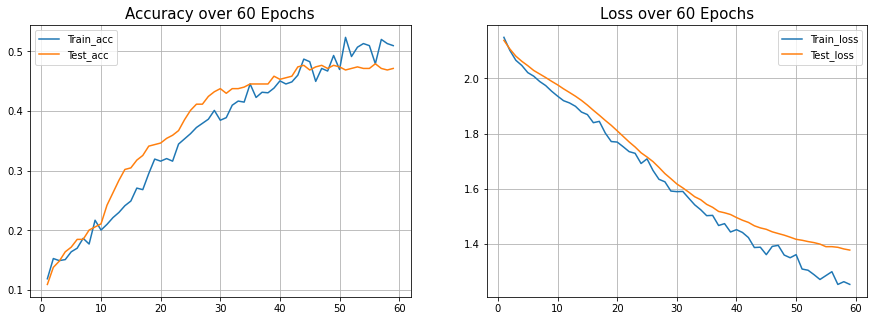

384/384 [==============================] - 0s 87us/step
Test loss: 1.332356062096854
Test accuracy: 0.5
Test precision: 0.24866490066051483
Test Recall: 0.614820659160614
Test F1 Score:  0.35410972747680075
[16, 16]
Train on 1152 samples, validate on 384 samples
Epoch 1/60
1152/1152 [==============================] - 1s 447us/step - loss: 2.1349 - accuracy: 0.1424 - precision_40: 0.1361 - recall_40: 0.5600 - true_positives_40: 332.7361 - true_negatives_40: 1998.0000 - false_positives_40: 2090.0000 - false_negatives_40: 251.2639 - val_loss: 2.0577 - val_accuracy: 0.1354 - val_precision_40: 0.1386 - val_recall_40: 0.5907 - val_true_positives_40: 799.9167 - val_true_negatives_40: 4496.5000 - val_false_positives_40: 4967.5000 - val_false_negatives_40: 552.0833
Epoch 2/60
1152/1152 [==============================] - 0s 290us/step - loss: 2.0889 - accuracy: 0.1545 - precision_40: 0.1414 - recall_40: 0.6139 - true_positives_40: 1300.7639 - true_negatives_40: 6938.5835 - false_positives_40: 79

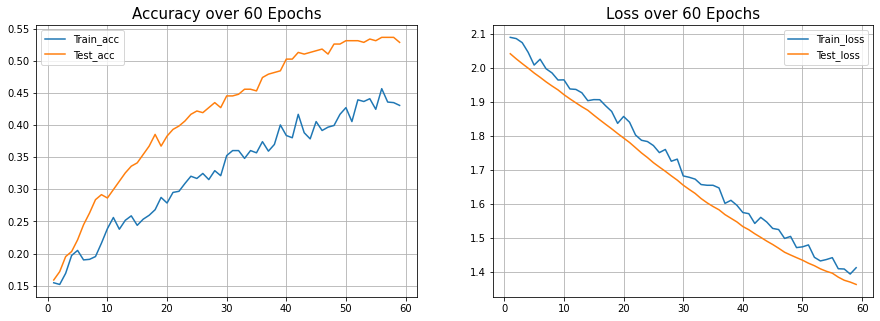

384/384 [==============================] - 0s 86us/step
Test loss: 1.2827129662036896
Test accuracy: 0.5494791865348816
Test precision: 0.22422437369823456
Test Recall: 0.6620736718177795
Test F1 Score:  0.3349957842206474
[32, 32]
Train on 1152 samples, validate on 384 samples
Epoch 1/60
1152/1152 [==============================] - 1s 442us/step - loss: 2.3072 - accuracy: 0.1406 - precision_41: 0.1290 - recall_41: 0.5423 - true_positives_41: 319.2500 - true_negatives_41: 1945.5972 - false_positives_41: 2142.4028 - false_negatives_41: 264.7500 - val_loss: 2.1343 - val_accuracy: 0.1276 - val_precision_41: 0.1336 - val_recall_41: 0.5730 - val_true_positives_41: 774.9167 - val_true_negatives_41: 4440.7085 - val_false_positives_41: 5023.2915 - val_false_negatives_41: 577.0833
Epoch 2/60
1152/1152 [==============================] - 0s 282us/step - loss: 2.2052 - accuracy: 0.1389 - precision_41: 0.1344 - recall_41: 0.5807 - true_positives_41: 1232.4028 - true_negatives_41: 6904.7363 - false_

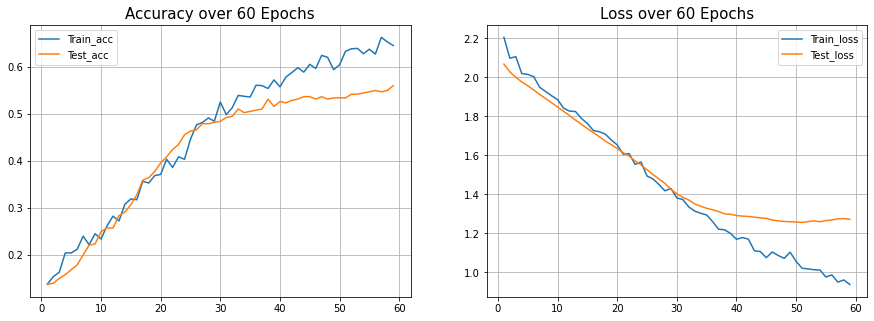

384/384 [==============================] - 0s 92us/step
Test loss: 1.2211046054338415
Test accuracy: 0.546875
Test precision: 0.27753114700317383
Test Recall: 0.6697091460227966
Test F1 Score:  0.392435053328389
[64, 32]
Train on 1152 samples, validate on 384 samples
Epoch 1/60
1152/1152 [==============================] - 1s 450us/step - loss: 2.2799 - accuracy: 0.1406 - precision_42: 0.1315 - recall_42: 0.4862 - true_positives_42: 288.7500 - true_negatives_42: 2206.4307 - false_positives_42: 1881.5695 - false_negatives_42: 295.2500 - val_loss: 2.1565 - val_accuracy: 0.1771 - val_precision_42: 0.1360 - val_recall_42: 0.5042 - val_true_positives_42: 682.0833 - val_true_negatives_42: 5132.3335 - val_false_positives_42: 4331.6665 - val_false_negatives_42: 669.9167
Epoch 2/60
1152/1152 [==============================] - 0s 278us/step - loss: 2.1947 - accuracy: 0.1580 - precision_42: 0.1357 - recall_42: 0.5087 - true_positives_42: 1080.6111 - true_negatives_42: 7970.7222 - false_positives_4

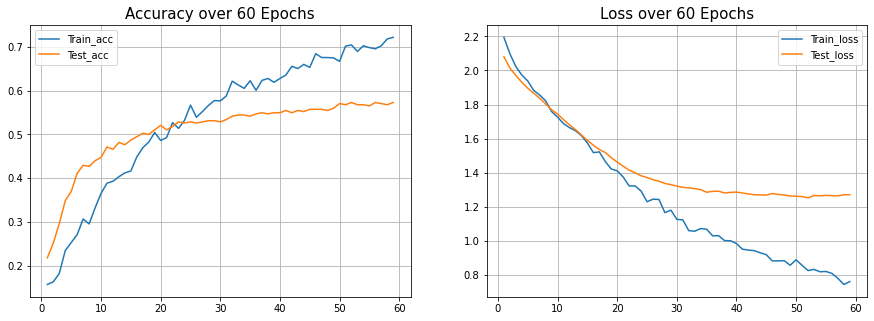

384/384 [==============================] - 0s 77us/step
Test loss: 1.2614130220220734
Test accuracy: 0.5833333134651184
Test precision: 0.3357154130935669
Test Recall: 0.6258924603462219
Test F1 Score:  0.43702168353852944
[64, 64]
Train on 1152 samples, validate on 384 samples
Epoch 1/60
1152/1152 [==============================] - 0s 434us/step - loss: 2.2272 - accuracy: 0.1363 - precision_43: 0.1304 - recall_43: 0.4425 - true_positives_43: 260.7778 - true_negatives_43: 2369.7917 - false_positives_43: 1718.2084 - false_negatives_43: 323.2222 - val_loss: 2.0501 - val_accuracy: 0.1745 - val_precision_43: 0.1378 - val_recall_43: 0.4685 - val_true_positives_43: 633.8333 - val_true_negatives_43: 5500.9585 - val_false_positives_43: 3963.0417 - val_false_negatives_43: 718.1667
Epoch 2/60
1152/1152 [==============================] - 0s 293us/step - loss: 2.0655 - accuracy: 0.1780 - precision_43: 0.1408 - recall_43: 0.4826 - true_positives_43: 1026.6250 - true_negatives_43: 8594.6113 - false_

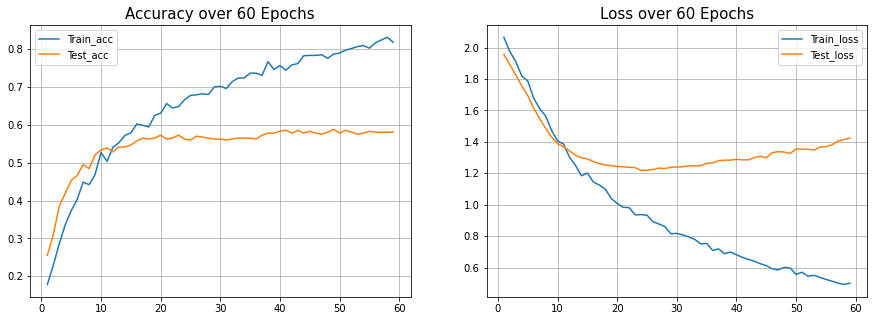

384/384 [==============================] - 0s 84us/step
Test loss: 1.310459843526284
Test accuracy: 0.5755208134651184
Test precision: 0.44999709725379944
Test Recall: 0.47202518582344055
Test F1 Score:  0.4607480043591082


In [ ]:
layers=[[32,16],[16,16],[32,32],[64,32],[64,64]]

for l in layers:
  print(l)
  model=create_model((df_echo_train.shape[1],),8,lyrs=l, dr=0.5, droprate=0.00025)
  history = model.fit(df_echo_train, df_echo_train_y,
                      batch_size=16,
                      epochs=60,
                      validation_data=(df_echo_valid, df_echo_valid_y))

  plot_acc_loss(history, 60)
  x= model.evaluate(df_echo_test,df_echo_test_y)
  print('Test loss:' , x[0])
  print('Test accuracy:',x[1])
  print('Test precision:' , x[2])
  print('Test Recall:',x[3])
  print('Test F1 Score: ',2*(x[2]*x[3])/(x[2]+x[3]))

<h3>Echo and Librosa</h3>

In [ ]:
df_tracks_echo=df_tracks[df_tracks.index.isin(df_echo.index.values.tolist())]
genres_echo=['Rock','Electronic','Hip-Hop','Folk','Old-Time / Historic',
             'Pop','Classical','Jazz']                    

df_tracks_echo_balanced_train=pd.DataFrame()
df_tracks_echo_balanced_valid=pd.DataFrame()
df_tracks_echo_balanced_test=pd.DataFrame()

for genre in genres_echo:
  df_tmp=df_tracks_echo[df_tracks_echo[('track','genre_top')]==genre]

  df_tracks_echo_balanced_train=pd.concat([df_tracks_echo_balanced_train,
                                            df_tmp[0:144]])
  
  df_tracks_echo_balanced_valid=pd.concat([df_tracks_echo_balanced_valid,
                                            df_tmp[144:192]])
  
  df_tracks_echo_balanced_test=pd.concat([df_tracks_echo_balanced_test,
                                            df_tmp[192:240]])
  
df_tracks_echo_balanced_train=df_tracks_echo_balanced_train.sort_index()
df_tracks_echo_balanced_valid=df_tracks_echo_balanced_valid.sort_index()
df_tracks_echo_balanced_test=df_tracks_echo_balanced_test.sort_index()

print(df_tracks_echo_balanced_train[('track','genre_top')].value_counts())
print(df_tracks_echo_balanced_valid[('track','genre_top')].value_counts())
print(df_tracks_echo_balanced_test[('track','genre_top')].value_counts())

df_cln_echo=pd.merge(df_echo.xs('temporal_features',level=1,axis=1), 
                       df_echo.xs('audio_features',level=1,axis=1), 
                       left_index=True, 
                       right_index=True)

print(len(df_cln_echo))
df_features_echo=df_features[df_features.index.isin(df_cln_echo.index.values.tolist())]
df_cln_echo=df_cln_echo.join(df_features_echo)
print(len(df_features_echo))
print(len(df_cln_echo))

indexes=df_cln_echo.index.values.tolist()
scaler=preprocessing.StandardScaler(copy=False)
df_cln_echo=scaler.fit_transform(df_cln_echo)
df_cln_echo=pd.DataFrame(data=df_cln_echo,index=indexes)

df_echo_train=df_cln_echo[df_cln_echo.index.isin(df_tracks_echo_balanced_train.index.values.tolist())]
df_echo_valid=df_cln_echo[df_cln_echo.index.isin(df_tracks_echo_balanced_valid.index.values.tolist())]
df_echo_test=df_cln_echo[df_cln_echo.index.isin(df_tracks_echo_balanced_test.index.values.tolist())]


df_echo_train=df_echo_train.sort_index()
df_echo_valid=df_echo_valid.sort_index()
df_echo_test=df_echo_test.sort_index()

df_echo_train_y=df_tracks_echo_balanced_train[('track','genre_top')]
df_echo_valid_y=df_tracks_echo_balanced_valid[('track','genre_top')]
df_echo_test_y=df_tracks_echo_balanced_test[('track','genre_top')]

print(df_echo_train.shape)
print(len(df_echo_train))
print(len(df_echo_train_y))

le=LabelEncoder()
df_echo_train_y=le.fit_transform(df_echo_train_y)
df_echo_valid_y=le.fit_transform(df_echo_valid_y)
df_echo_test_y=le.fit_transform(df_echo_test_y)

#train 
clf_svc_echo = SVC()
clf_svc_echo.fit(df_echo_train, df_echo_train_y)

#test
predictions=clf_svc_echo.predict(df_echo_test)
labels = [0,1,2,3,4,5,6,7]
target_names = le.inverse_transform(labels)
print(classification_report(df_echo_test_y, predictions, target_names=target_names))

df_echo_train_y = to_categorical(df_echo_train_y)
df_echo_valid_y = to_categorical(df_echo_valid_y)
df_echo_test_y = to_categorical(df_echo_test_y)

Hip-Hop                144
Electronic             144
Pop                    144
Folk                   144
Classical              144
Rock                   144
Jazz                   144
Old-Time / Historic    144
Name: (track, genre_top), dtype: int64
Classical              48
Folk                   48
Hip-Hop                48
Rock                   48
Pop                    48
Electronic             48
Jazz                   48
Old-Time / Historic    48
Name: (track, genre_top), dtype: int64
Classical              48
Folk                   48
Hip-Hop                48
Rock                   48
Pop                    48
Electronic             48
Jazz                   48
Old-Time / Historic    48
Name: (track, genre_top), dtype: int64
13129
13129
13129


/usr/local/lib/python3.6/dist-packages/pandas/core/reshape/merge.py:618: UserWarning: merging between different levels can give an unintended result (2 levels on the left, 3 on the right)
  warnings.warn(msg, UserWarning)


(1152, 750)
1152
1152
                     precision    recall  f1-score   support

          Classical       0.96      0.96      0.96        48
         Electronic       0.69      0.46      0.55        48
               Folk       0.49      0.71      0.58        48
            Hip-Hop       0.67      0.79      0.72        48
               Jazz       0.70      0.54      0.61        48
Old-Time / Historic       0.98      1.00      0.99        48
                Pop       0.30      0.42      0.35        48
               Rock       0.84      0.44      0.58        48

           accuracy                           0.66       384
          macro avg       0.70      0.66      0.67       384
       weighted avg       0.70      0.66      0.67       384



In [ ]:
import numpy as np


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

Hip-Hop                144
Electronic             144
Pop                    144
Folk                   144
Classical              144
Rock                   144
Jazz                   144
Old-Time / Historic    144
Name: (track, genre_top), dtype: int64
Classical              48
Folk                   48
Hip-Hop                48
Rock                   48
Pop                    48
Electronic             48
Jazz                   48
Old-Time / Historic    48
Name: (track, genre_top), dtype: int64
Classical              48
Folk                   48
Hip-Hop                48
Rock                   48
Pop                    48
Electronic             48
Jazz                   48
Old-Time / Historic    48
Name: (track, genre_top), dtype: int64


/usr/local/lib/python3.6/dist-packages/pandas/core/reshape/merge.py:618: UserWarning: merging between different levels can give an unintended result (2 levels on the left, 3 on the right)
  warnings.warn(msg, UserWarning)


(1152, 201)
1152
                     precision    recall  f1-score   support

          Classical       0.98      0.96      0.97        48
         Electronic       0.69      0.42      0.52        48
               Folk       0.49      0.73      0.59        48
            Hip-Hop       0.66      0.81      0.73        48
               Jazz       0.72      0.58      0.64        48
Old-Time / Historic       0.98      1.00      0.99        48
                Pop       0.30      0.40      0.34        48
               Rock       0.81      0.44      0.57        48

           accuracy                           0.67       384
          macro avg       0.70      0.67      0.67       384
       weighted avg       0.70      0.67      0.67       384



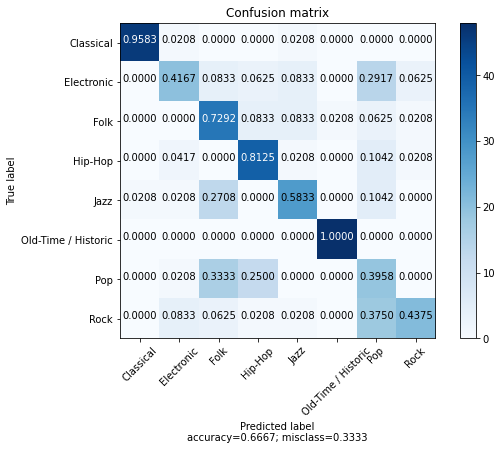

In [ ]:
genres_echo=['Rock','Electronic','Hip-Hop','Folk','Old-Time / Historic',
             'Pop','Classical','Jazz']                    

df_tracks_echo_balanced_train=pd.DataFrame()
df_tracks_echo_balanced_valid=pd.DataFrame()
df_tracks_echo_balanced_test=pd.DataFrame()

for genre in genres_echo:
  df_tmp=df_tracks_echo[df_tracks_echo[('track','genre_top')]==genre]

  df_tracks_echo_balanced_train=pd.concat([df_tracks_echo_balanced_train,
                                            df_tmp[0:144]])
  
  df_tracks_echo_balanced_valid=pd.concat([df_tracks_echo_balanced_valid,
                                            df_tmp[144:192]])
  
  df_tracks_echo_balanced_test=pd.concat([df_tracks_echo_balanced_test,
                                            df_tmp[192:240]])
  
df_tracks_echo_balanced_train=df_tracks_echo_balanced_train.sort_index()
df_tracks_echo_balanced_valid=df_tracks_echo_balanced_valid.sort_index()
df_tracks_echo_balanced_test=df_tracks_echo_balanced_test.sort_index()

print(df_tracks_echo_balanced_train[('track','genre_top')].value_counts())
print(df_tracks_echo_balanced_valid[('track','genre_top')].value_counts())
print(df_tracks_echo_balanced_test[('track','genre_top')].value_counts())

df_cln_echo=pd.merge(df_echo.xs('temporal_features',level=1,axis=1), 
                       df_echo.xs('audio_features',level=1,axis=1), 
                       left_index=True, 
                       right_index=True)

df_features_echo=df_features[df_features.index.isin(df_cln_echo.index.values.tolist())]
df_cln_echo=df_cln_echo.join(df_features_echo)

indexes=df_cln_echo.index.values.tolist()
scaler=preprocessing.StandardScaler(copy=False)
df_cln_echo=scaler.fit_transform(df_cln_echo)
#df_cln_echo=pd.DataFrame(data=df_cln_echo,index=indexes)

pca=PCA(0.90)
principal_components=pca.fit_transform(df_cln_echo)
df_cln_echo=pd.DataFrame(data=principal_components,index=indexes)

df_echo_train=df_cln_echo[df_cln_echo.index.isin(df_tracks_echo_balanced_train.index.values.tolist())]
df_echo_valid=df_cln_echo[df_cln_echo.index.isin(df_tracks_echo_balanced_valid.index.values.tolist())]
df_echo_test=df_cln_echo[df_cln_echo.index.isin(df_tracks_echo_balanced_test.index.values.tolist())]


df_echo_train=df_echo_train.sort_index()
df_echo_valid=df_echo_valid.sort_index()
df_echo_test=df_echo_test.sort_index()

df_echo_train_y=df_tracks_echo_balanced_train[('track','genre_top')]
df_echo_valid_y=df_tracks_echo_balanced_valid[('track','genre_top')]
df_echo_test_y=df_tracks_echo_balanced_test[('track','genre_top')]

print(df_echo_train.shape)
print(len(df_echo_train_y))

le=LabelEncoder()
df_echo_train_y=le.fit_transform(df_echo_train_y)
df_echo_valid_y=le.fit_transform(df_echo_valid_y)
df_echo_test_y=le.fit_transform(df_echo_test_y)

#train 
clf_svc_echo = SVC()
clf_svc_echo.fit(df_echo_train, df_echo_train_y)

#test
predictions=clf_svc_echo.predict(df_echo_test)
labels = [0,1,2,3,4,5,6,7]
target_names = le.inverse_transform(labels)
print(classification_report(df_echo_test_y, predictions, target_names=target_names))
df_echo_test_y_old=df_echo_test_y
df_echo_train_y = to_categorical(df_echo_train_y)
df_echo_valid_y = to_categorical(df_echo_valid_y)
df_echo_test_y = to_categorical(df_echo_test_y)



from sklearn.metrics import confusion_matrix
cm=confusion_matrix(df_echo_test_y_old, predictions)
plot_confusion_matrix(cm,target_names)

[128, 64, 32]
Train on 1152 samples, validate on 384 samples
Epoch 1/60
1152/1152 [==============================] - 1s 746us/step - loss: 2.4049 - accuracy: 0.1415 - precision_5: 0.1323 - recall_5: 0.5478 - true_positives_5: 322.1528 - true_negatives_5: 2001.8195 - false_positives_5: 2086.1807 - false_negatives_5: 261.8472 - val_loss: 2.0393 - val_accuracy: 0.1302 - val_precision_5: 0.1379 - val_recall_5: 0.5868 - val_true_positives_5: 794.6250 - val_true_negatives_5: 4498.6250 - val_false_positives_5: 4965.3750 - val_false_negatives_5: 557.3750
Epoch 2/60
1152/1152 [==============================] - 1s 532us/step - loss: 2.1382 - accuracy: 0.1684 - precision_5: 0.1415 - recall_5: 0.6182 - true_positives_5: 1311.9166 - true_negatives_5: 6886.8887 - false_positives_5: 7953.1113 - false_negatives_5: 808.0833 - val_loss: 1.9987 - val_accuracy: 0.1667 - val_precision_5: 0.1421 - val_recall_5: 0.6292 - val_true_positives_5: 1817.8750 - val_true_negatives_5: 9245.2500 - val_false_positives_

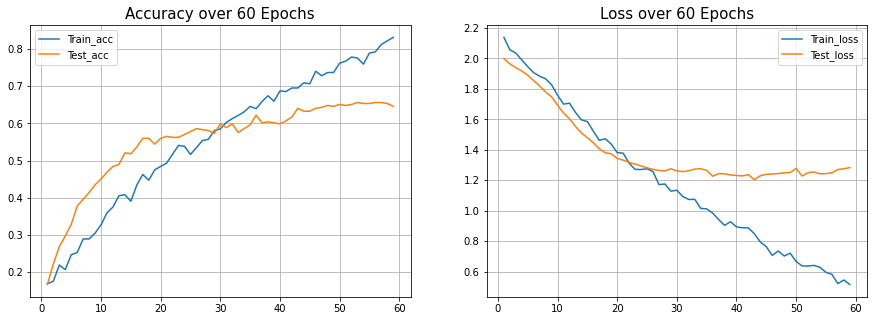

384/384 [==============================] - 0s 168us/step
Test loss: 1.305248957243748
Test accuracy: 0.6354166865348816
Test precision: 0.3245733678340912
Test Recall: 0.7358989119529724
Test F1 Score:  0.4504656892794593
[64, 64, 32]
Train on 1152 samples, validate on 384 samples
Epoch 1/60
1152/1152 [==============================] - 1s 696us/step - loss: 2.4406 - accuracy: 0.1354 - precision_6: 0.1261 - recall_6: 0.5249 - true_positives_6: 313.4445 - true_negatives_6: 1952.3750 - false_positives_6: 2135.6250 - false_negatives_6: 270.5555 - val_loss: 2.1182 - val_accuracy: 0.1536 - val_precision_6: 0.1342 - val_recall_6: 0.5708 - val_true_positives_6: 772.2083 - val_true_negatives_6: 4482.0415 - val_false_positives_6: 4981.9585 - val_false_negatives_6: 579.7917
Epoch 2/60
1152/1152 [==============================] - 1s 501us/step - loss: 2.2207 - accuracy: 0.1354 - precision_6: 0.1331 - recall_6: 0.5724 - true_positives_6: 1215.0139 - true_negatives_6: 6936.7085 - false_positives_6: 

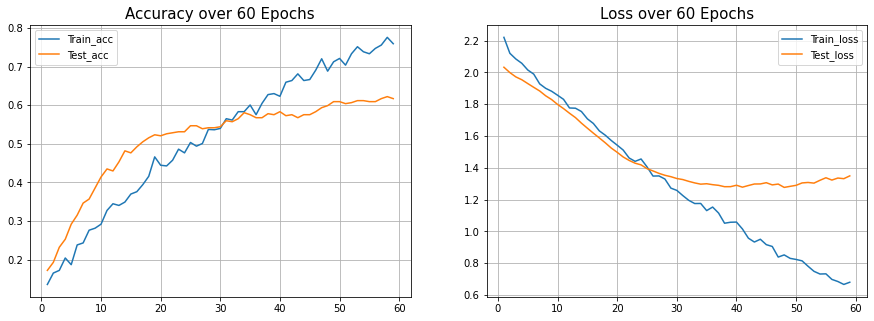

384/384 [==============================] - 0s 151us/step
Test loss: 1.2305355070857331
Test accuracy: 0.625
Test precision: 0.29144272208213806
Test Recall: 0.7007198929786682
Test F1 Score:  0.4116658094687262
[32, 32, 32]
Train on 1152 samples, validate on 384 samples
Epoch 1/60
1152/1152 [==============================] - 1s 739us/step - loss: 2.4591 - accuracy: 0.1319 - precision_7: 0.1272 - recall_7: 0.4377 - true_positives_7: 254.5972 - true_negatives_7: 2313.4443 - false_positives_7: 1774.5555 - false_negatives_7: 329.4028 - val_loss: 2.0988 - val_accuracy: 0.1719 - val_precision_7: 0.1304 - val_recall_7: 0.4620 - val_true_positives_7: 626.3750 - val_true_negatives_7: 5299.6665 - val_false_positives_7: 4164.3335 - val_false_negatives_7: 725.6250
Epoch 2/60
1152/1152 [==============================] - 1s 493us/step - loss: 2.3156 - accuracy: 0.1415 - precision_7: 0.1328 - recall_7: 0.4795 - true_positives_7: 1017.8750 - true_negatives_7: 8195.2637 - false_positives_7: 6644.7363 -

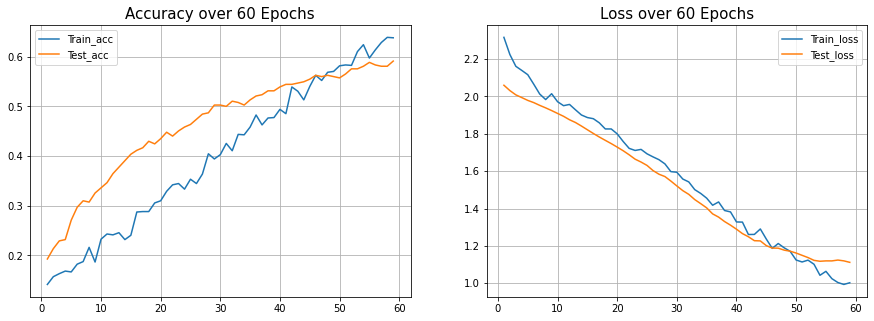

384/384 [==============================] - 0s 159us/step
Test loss: 1.1778113863741357
Test accuracy: 0.578125
Test precision: 0.24872373044490814
Test Recall: 0.6928608417510986
Test F1 Score:  0.36604451331995447
[32, 32, 32, 16]
Train on 1152 samples, validate on 384 samples
Epoch 1/60
1152/1152 [==============================] - 1s 776us/step - loss: 2.4511 - accuracy: 0.1302 - precision_8: 0.1181 - recall_8: 0.4970 - true_positives_8: 298.7778 - true_negatives_8: 1907.5972 - false_positives_8: 2180.4028 - false_negatives_8: 285.2222 - val_loss: 2.0497 - val_accuracy: 0.1406 - val_precision_8: 0.1256 - val_recall_8: 0.5521 - val_true_positives_8: 749.0833 - val_true_negatives_8: 4262.5835 - val_false_positives_8: 5201.4165 - val_false_negatives_8: 602.9167
Epoch 2/60
1152/1152 [==============================] - 1s 537us/step - loss: 2.3074 - accuracy: 0.1311 - precision_8: 0.1296 - recall_8: 0.5783 - true_positives_8: 1226.0834 - true_negatives_8: 6609.5137 - false_positives_8: 823

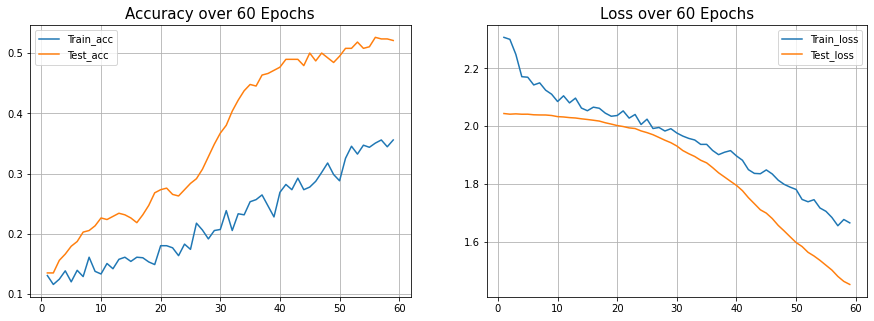

384/384 [==============================] - 0s 145us/step
Test loss: 1.487881362438202
Test accuracy: 0.5052083134651184
Test precision: 0.17132426798343658
Test Recall: 0.756831169128418
Test F1 Score:  0.27940049878164663


In [ ]:
layers=[[128,64,32],[64,64,32],[32,32,32],[32,32,32,16]]

for l in layers:
  print(l)
  model=create_model((df_echo_train.shape[1],),8,lyrs=l, dr=0.5, droprate=0.00025)
  history = model.fit(df_echo_train, df_echo_train_y,
                      batch_size=16,
                      epochs=60,
                      validation_data=(df_echo_valid, df_echo_valid_y))

  plot_acc_loss(history, 60)
  x= model.evaluate(df_echo_test,df_echo_test_y)
  print('Test loss:' , x[0])
  print('Test accuracy:',x[1])
  print('Test precision:' , x[2])
  print('Test Recall:',x[3])
  print('Test F1 Score: ',2*(x[2]*x[3])/(x[2]+x[3]))